<a href="https://colab.research.google.com/github/jrod-projects-hub/Portfolio-Projects/blob/main/Beats_proj3_df.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
start_time = time.time()
print("Expected runtime of approximately 15 minutes","\nNotebook run started...")

Notebook run started...


# TASK 1 Clean Dataset

In [ ]:
!pip install python-docx
!pip install textblob
#!pip install google-genai
!pip install google.generativeai

In [ ]:
import docx
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import io
import base64
import os
# from google import genai
# from google.genai import types
from google.colab import userdata
import google.generativeai as genai
import concurrent.futures
import time

In [ ]:
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["product","one", "quality", "great", "good", "love", "really", "use", "used", "just", "get", "bought", "will", "speaker", "sound", "speakers", "t"])

In [ ]:
def parse_and_reformat_beats(docx_path):
    """
    Parses text from a docx file, splits by '|', and reformats sections into tuple strings.

    Args:
        docx_path (str): The path to the docx file.

    Returns:
        list: A list of reformatted tuple strings.
    """
    doc = docx.Document(docx_path)
    text = []
    for paragraph in doc.paragraphs:
        text.append(paragraph.text)
    full_text = "\n".join(text)

    # Split the text by the '|' delimiter
    sections = full_text.split('|')

    reformatted_tuples = []
    for section in sections:
        section = section.strip() # Remove leading/trailing whitespace
        if not section: # Skip empty sections
            continue

        # Use regex to capture the first two comma-separated parts and the rest
        match = re.match(r"([^,]+),\s*([^,]+),\s*(.*)", section)
        if match:
            product_id = match.group(1).strip()
            product_type = match.group(2).strip()
            # The rest of the string is the third element, handle newlines within it
            remaining_string = match.group(3).strip().replace('\n', ' ')

            # Format as a Python-like tuple string
            reformatted_tuple = f"('{product_id}', '{product_type}', '{remaining_string}')"
            reformatted_tuples.append(reformatted_tuple)
        else:
            print(f"Could not parse section: {section}") # Optional: print sections that don't match the pattern

    return reformatted_tuples

# Replace 'Unique Product IDs.docx' with the actual path to your file if it's different
file_path = '/content/Unique Product IDs.docx'
reformatted_data = parse_and_reformat_beats(file_path)

# Convert the list of strings (which are in tuple format) to a list of actual tuples
# Remove the surrounding parentheses and the trailing comma, then split by comma
# Added error handling in case a string doesn't match the expected tuple format
tuple_data = []
for item in reformatted_data:
    try:
        # Remove the surrounding parentheses and the trailing comma
        cleaned_item = item[1:-2]
        # Split by the first two commas only
        parts = cleaned_item.split(',', 2)
        if len(parts) == 3:
            # Strip whitespace from each part
            stripped_parts = [part.strip().strip("'") for part in parts]
            tuple_data.append(tuple(stripped_parts))
        else:
            print(f"Skipping item due to unexpected format: {item}")
    except Exception as e:
        print(f"Error processing item {item}: {e}")
        continue


# Create a DataFrame from the list of tuples
df = pd.DataFrame(tuple_data, columns=['product_id', 'product_type', 'product_name'])

# Print the reformatted data with '|' separator (optional, as per previous request)
print("|\n".join(reformatted_data) + "|")

# Display the first few rows of the DataFrame
print("\nDataFrame created from the data:")
display(df.head())

Could not parse section: 18 Hours of Battery Life
Could not parse section: Apple & Android Compatibility
Could not parse section: Built-in Microphone - Transparent Red
('B09GJVTRNZ', 'speaker', '‘JBL Flip 6 - Portable Bluetooth Speaker, powerful sound and deep bass, IPX7 waterproof, 12 hours of playtime, JBL PartyBoost for multiple speaker pairing for home, outdoor and travel (Black)’')|
('(B0BYC52LYP', 'speaker', '‘Ultimate Ears EVERBOOM’)')|
('(B08X4YMTPM', 'speaker', '‘JBL Charge 5 - Portable Bluetooth Speaker with IP67 Waterproof and USB Charge Out’)')|
('(B0D6WD2QSQ', 'speaker', '‘Bose SoundLink Flex Bluetooth Speaker’)')|
('(B0DYB6KMJH', 'speaker', '‘Sony ULT Field 1 Waterproof Portable Bluetooth Speaker, Enhanced Bass, 12h Battery, IP67 Rated Dustproof Shockproof Rustproof, Detachable Strap (SRSULT10B)’)')|
('B0CVFKZ1LC', 'speaker', 'Ultimate Ears Boom 4')|
('B0BW34LCB8', 'speaker', 'Sonos Era 100 - White - Wireless, Alexa Enabled Smart Speaker')|
('B09PYVXXW5', 'earbud', '1MORE

product_id product_type                                       product_name
0   B09GJVTRNZ      speaker  ‘JBL Flip 6 - Portable Bluetooth Speaker, powe...
1  (B0BYC52LYP      speaker                          ‘Ultimate Ears EVERBOOM’)
2  (B08X4YMTPM      speaker  ‘JBL Charge 5 - Portable Bluetooth Speaker wit...
3  (B0D6WD2QSQ      speaker           ‘Bose SoundLink Flex Bluetooth Speaker’)
4  (B0DYB6KMJH      speaker  ‘Sony ULT Field 1 Waterproof Portable Bluetoot...

In [ ]:
# Assuming the reformatted_data list from the previous cell is available
# If not, you might need to re-run the extraction or load it from a file
data = reformatted_data

# Convert the list of strings (which are in tuple format) to a list of actual tuples
# Corrected parsing to handle commas within the product_name and extra quotes/parentheses
tuple_data = []
for item_str in data:
    # First, try to remove outer layers of quotes and parentheses that might exist from string representation
    cleaned_item = item_str.strip("()'") # Remove outer parentheses and single quotes

    # Check for cases where the string might start with "('" and end with "')"
    # or similar patterns that are string representations of Python tuples.
    # This handles cases like "('B09GJVTRNZ', 'speaker', ...)" and "('(B0BYC52LYP', 'speaker', ...)')"
    if cleaned_item.startswith("('") and cleaned_item.endswith("')"):
        cleaned_item = cleaned_item[2:-2] # Remove "('" and "')"
    elif cleaned_item.startswith("'") and cleaned_item.endswith("'"):
        cleaned_item = cleaned_item[1:-1] # Remove just outer single quotes

    # Split by the first two commas only to separate product_id, product_type, and product_name
    parts = cleaned_item.split(',', 2)

    if len(parts) == 3:
        # Strip whitespace and any remaining single/double quotes from each part
        product_id = parts[0].strip().strip("'\"")
        product_type = parts[1].strip().strip("'\"")
        product_name = parts[2].strip().strip("'\"")
        tuple_data.append((product_id, product_type, product_name))
    else:
        print(f"Skipping item due to unexpected format after initial cleaning: {item_str} -> {cleaned_item}. Parts: {parts}")


# Create a DataFrame from the list of tuples
df_csv = pd.DataFrame(tuple_data, columns=['product_id', 'product_type', 'product_name'])

# Display the first few rows of the DataFrame
print("DataFrame from CSV data:")
display(df_csv.head())

# --- Now, create a DataFrame from the Excel file and merge ---
# Replace 'path/to/your/excel_file.xlsx' with the actual path to your Excel file
excel_file_path = '/content/new_reference_data_for_beats - new_reference_data_for_beats.csv' # Assuming the user meant the CSV file they uploaded
df_excel = pd.read_csv(excel_file_path)

# Assuming the Excel file also has a column named 'product_id' to merge on
merged_df = pd.merge(df_csv, df_excel, on='product_id', how='inner') # Use 'inner' merge for common product_ids

print("\nMerged DataFrame:")
display(merged_df.head())

DataFrame from CSV data:


product_id product_type                                       product_name
0  B09GJVTRNZ      speaker  ‘JBL Flip 6 - Portable Bluetooth Speaker, powe...
1  B0BYC52LYP      speaker                           ‘Ultimate Ears EVERBOOM’
2  B08X4YMTPM      speaker  ‘JBL Charge 5 - Portable Bluetooth Speaker wit...
3  B0D6WD2QSQ      speaker            ‘Bose SoundLink Flex Bluetooth Speaker’
4  B0DYB6KMJH      speaker  ‘Sony ULT Field 1 Waterproof Portable Bluetoot...


Merged DataFrame:


product_id product_type                                       product_name  \
0  B09GJVTRNZ      speaker  ‘JBL Flip 6 - Portable Bluetooth Speaker, powe...   
1  B09GJVTRNZ      speaker  ‘JBL Flip 6 - Portable Bluetooth Speaker, powe...   
2  B09GJVTRNZ      speaker  ‘JBL Flip 6 - Portable Bluetooth Speaker, powe...   
3  B09GJVTRNZ      speaker  ‘JBL Flip 6 - Portable Bluetooth Speaker, powe...   
4  B09GJVTRNZ      speaker  ‘JBL Flip 6 - Portable Bluetooth Speaker, powe...   

        review_id                                              title  \
0  R1TIU27G892G8N  5.0 out of 5 stars Best for modern music; fine...   
1  R3UHPD69SUVF4D  5.0 out of 5 stars Incredible Sound and Perfor...   
2   R8ZPP4M7T18BO              5.0 out of 5 stars The Sound Is Great   
3  R3T9HSXO492VDG  5.0 out of 5 stars Incredible Sound and Durabi...   
4   RF4X9MUCFL4QZ       5.0 out of 5 stars Not too small Not too big   

                             author  rating  \
0  Glut & Lack: troublemaking twins       5   
1                              Seva       5   
2                          Michelle       5   
3                    Paola J Franco       5   
4                         Nikki Fox       5   

                                             content  \
0  Love this little speaker for the music I (and ...   
1  I recently bought the JBL Flip 6 Portable Blue...   
2  I'm so glad I bought this. I use it daily I ha...   
3  The sound quality is amazing for such a compac...   
4  These are not huge, but great for my sports pl...   

                                         timestamp  \
0   Reviewed in the United States January 14, 2025   
1    Reviewed in the United States January 4, 2025   
2     Reviewed in the United States April 16, 2025   
3  Reviewed in the United States February 28, 2025   
4     Reviewed in the United States April 17, 2025   

                     profile_id  is_verified  helpful_count  \
0  AEMU5GYR7E7YH5B64AKBUNZ5Y4PA            1             19   
1  AF2OOF3FJWVX65HP72K6CVPMONRA            1             14   
2  AHHSFRGEAFWTV24U7MFCK7V54P7Q            1              1   
3  AGIUPLMVY4PLRDFR6DCBYAG53LWQ            1              6   
4  AEP7HYGSBZ5Q2DII5UM2CWYXUQUA            1              1   

            product_attributes  
0   Color: Blue, Style: Flip 6  
1   Color: Teal, Style: Flip 6  
2   Color: Blue, Style: Flip 6  
3  Color: White, Style: Flip 6  
4   Color: Blue, Style: Flip 6

In [ ]:
def parse_docx_to_tuples(docx_path):
    """
    Parses text from a docx file, splits by '|', and extracts data into a list of tuples.

    Args:
        docx_path (str): The path to the docx file.

    Returns:
        list: A list of tuples containing the extracted data.
    """
    doc = docx.Document(docx_path)
    text = []
    for paragraph in doc.paragraphs:
        text.append(paragraph.text)
    full_text = "\n".join(text)

    # Split the text by the '|' delimiter
    sections = full_text.split('|')

    tuple_data = []
    for section in sections:
        section = section.strip() # Remove leading/trailing whitespace
        if not section: # Skip empty sections
            continue

        # Use regex to capture the first two comma-separated parts and the rest
        match = re.match(r"([^,]+),\s*([^,]+),\s*(.*)", section)
        if match:
            product_id = match.group(1).strip()
            product_type = match.group(2).strip()
            # The rest of the string is the third element, handle newlines within it
            remaining_string = match.group(3).strip().replace('\n', ' ')

            # Append as an actual tuple
            tuple_data.append((product_id, product_type, remaining_string))
        else:
            print(f"Could not parse section: {section}") # Optional: print sections that don't match the pattern

    return tuple_data

# Replace 'unique product ids 2.docx' with the actual path to your file
file_path_2 = '/content/unique product ids 2.docx'
tuple_list_2 = parse_docx_to_tuples(file_path_2)

# Create a DataFrame from the list of tuples
df_from_docx2 = pd.DataFrame(tuple_list_2, columns=['product_id', 'product_type', 'product_name'])

# Clean the DataFrame
# Remove leading '(' and trailing ')' from all string columns
for col in df_from_docx2.select_dtypes(include='object').columns:
    df_from_docx2[col] = df_from_docx2[col].str.lstrip('(').str.rstrip(')')

# Convert 'earbuds' to 'earbud' in the 'product_type' column
# Updated to replace 'earbuds' including the quotes
df_from_docx2['product_type'] = df_from_docx2['product_type'].replace("'earbuds'", "'earbud'")

# Remove single quotes from the 'product_id' column
df_from_docx2['product_id'] = df_from_docx2['product_id'].str.replace("'", "")


# Display the entire DataFrame after cleaning
print("DataFrame created from 'unique product ids 2.docx' after cleaning:")
display(df_from_docx2)

DataFrame created from 'unique product ids 2.docx' after cleaning:


product_id product_type                                       product_name
0   B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...
1   B0BYC52LYP    'speaker'                           'Ultimate Ears EVERBOOM'
2   B08X4YMTPM    'speaker'  'JBL Charge 5 - Portable Bluetooth Speaker wit...
3   B0D6WD2QSQ    'speaker'           '‘Bose SoundLink Flex Bluetooth Speaker'
4   B0DYB6KMJH    'speaker'  '‘Sony ULT Field 1 Waterproof Portable Bluetoo...
5   B0CVFKZ1LC    'speaker'                             'Ultimate Ears Boom 4'
6   B0BW34LCB8    'speaker'  'Sonos Era 100 - White - Wireless, Alexa Enabl...
7   B09PYVXXW5     'earbud'  '1MORE ComfoBuds Mini Hybrid Active Noise Canc...
8   B09H27SXHS     'earbud'                        'HTC Earbuds Charging Case'
9   B09FM6PDHP     'earbud'  'JBL Tune 230NC TWS True Wireless in-Ear Noise...
10  B09HN594TL     'earbud'  'JLab Go Air Pop True Wireless Earbuds, in Ear...
11  B096SV8SJG     'earbud'                                'Beats Studio Buds'
12  B0BTZKP1TP     'earbud'  'Jabra Elite 4 True Wireless Earbuds - Active ...
13  B08ZR5JB9G     'earbud'                      'Sennheiser CX True Wireless'
14  B0C2F5KD26     'earbud'                          'Skullcandy Smokin' Buds'
15  B0BYPFNW6T     'earbud'  'Sony WF-C700N Truly Wireless Noise Canceling ...
16  B093SLWMS7     'earbud'  'Soundcore by Anker Life P3 Noise Cancelling E...
17  B0CXL4FQBK    'speaker'  'Sony ULT Field 1 Waterproof Portable Bluetoot...
18  B099TJGJ91    'speaker'            'Bose SoundLink Flex Bluetooth Speaker'
19  B0D4SX9RC6    'speaker'                                       'Beats Pill'
20  B0B44F1GGK    'speaker'  'Sony SRS-XE200 X-Series Wireless Ultra Portab...
21  B0BG93TZ5N    'speaker'  'Tronsmart Bang SE Portable Bluetooth Speaker,...
22  B09XXW54QG    'speaker'  'Marshall Emberton II Portable Bluetooth Speaker'
23  B07DD3WBYW    'speaker'  'Ultimate Ears Boom 3 Portable Waterproof Blue...
24  B07YBN9XXG    'speaker'  'Bose SoundLink Mini II Bluetooth Speaker Spec...
25  B0CY6S748H    'speaker'                                     'Sonos Roam 2'
26  B01IOD7KB6    'speaker'  'House of Marley - Get Together Bluetooth Port...
27  B0CVFM97GD    'speaker'  'Ultimate Ears MEGABOOM 4 Portable Waterproof ...
28  B08NLCW9WY    'speaker'  'JBL Xtreme 3 - Portable Bluetooth Speaker, Po...
29  B08YRT9T38    'speaker'  'Bang & Olufsen Beosound Explore - Wireless Po...
30  B08VL5S148    'speaker'  'Bose SoundLink Revolve+ (Series II) Bluetooth...
31  B097XX34SL    'speaker'  'Monster S320 Bluetooth Speaker, 40W True Wire...
32  B07PXGQC1Q     'earbud'  'Apple AirPods (2nd Generation) Wireless Ear B...
33  B0BZ9WMLNQ     'earbud'  'Google Pixel Buds A-Series - Wireless Earbuds...
34  B0D3JB14QS     'earbud'     'Beats Solo Buds - Wireless Bluetooth Earbuds'
35  B0BQPNMXQV     'earbud'  'JBL Vibe Beam - True Wireless JBL Deep Bass S...
36  B0C1QWWZR4     'earbud'  'JBL Tune Buds - True wireless Noise Cancellin...
37  B09CKF166Y     'earbud'  'SAMSUNG Galaxy Buds2 True Wireless Earbuds No...
38  B0CF7GYNW2     'earbud'  'SAMSUNG Galaxy Buds FE, Comfort and Secure Fi...
39  B09CFP6J6D     'earbud'  'Sony WF-C500 Truly Wireless in-Ear Bluetooth ...
40  B0BZTCXG6T     'earbud'  'Panasonic ErgoFit True Wireless Earbuds with ...
41  B0863H1JKB     'earbud'                  'Panasonic True Wireless Earbuds'
42  B09JL41N9C     'earbud'                                    'Beats Fit Pro'
43  B09V9P5Q6W     'earbud'  'Jbl Live Pro 2 Bluetooth Headphone In Ear hea...
44  B0BZK2Z2TC     'earbud'                              'Beats Studio Buds +'
45  B0C345M3T7     'earbud'  'Sony WF-1000XM5 The Best Truly Wireless Bluet...
46  B0CD2FSRDD     'earbud'  'Bose Quietcomfort Ultra Wireless 882826 In Ea...
47  B0CPFV77W4     'earbud'  'Bose Ultra Open Wireless 881046 On Ear headph...
48  B0B1NGPY94     'earbud'                                   'Pixel Buds Pro'
49  B0BYSQDWRT     'earbud'      'SHOKZ OpenFit Over E

In [ ]:


# Load the data from the CSV file into a DataFrame
csv_file_path = '/content/new_reference_data_for_beats - new_reference_data_for_beats.csv'
df_csv = pd.read_csv(csv_file_path)

# Assuming df_from_docx2 DataFrame is already created and available from the previous cell
# If not, you would need to run the previous cell first or load the DataFrame

# Perform the merge operation on the 'product_id' column
# Using an inner merge to only include rows where product_id exists in both DataFrames
merged_df = pd.merge(df_from_docx2, df_csv, on='product_id', how='inner')

# Display the first few rows of the merged DataFrame
print("Merged DataFrame:")
display(merged_df.head())

Merged DataFrame:


product_id product_type                                       product_name  \
0  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   
1  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   
2  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   
3  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   
4  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   

        review_id                                              title  \
0  R1TIU27G892G8N  5.0 out of 5 stars Best for modern music; fine...   
1  R3UHPD69SUVF4D  5.0 out of 5 stars Incredible Sound and Perfor...   
2   R8ZPP4M7T18BO              5.0 out of 5 stars The Sound Is Great   
3  R3T9HSXO492VDG  5.0 out of 5 stars Incredible Sound and Durabi...   
4   RF4X9MUCFL4QZ       5.0 out of 5 stars Not too small Not too big   

                             author  rating  \
0  Glut & Lack: troublemaking twins       5   
1                              Seva       5   
2                          Michelle       5   
3                    Paola J Franco       5   
4                         Nikki Fox       5   

                                             content  \
0  Love this little speaker for the music I (and ...   
1  I recently bought the JBL Flip 6 Portable Blue...   
2  I'm so glad I bought this. I use it daily I ha...   
3  The sound quality is amazing for such a compac...   
4  These are not huge, but great for my sports pl...   

                                         timestamp  \
0   Reviewed in the United States January 14, 2025   
1    Reviewed in the United States January 4, 2025   
2     Reviewed in the United States April 16, 2025   
3  Reviewed in the United States February 28, 2025   
4     Reviewed in the United States April 17, 2025   

                     profile_id  is_verified  helpful_count  \
0  AEMU5GYR7E7YH5B64AKBUNZ5Y4PA            1             19   
1  AF2OOF3FJWVX65HP72K6CVPMONRA            1             14   
2  AHHSFRGEAFWTV24U7MFCK7V54P7Q            1              1   
3  AGIUPLMVY4PLRDFR6DCBYAG53LWQ            1              6   
4  AEP7HYGSBZ5Q2DII5UM2CWYXUQUA            1              1   

            product_attributes  
0   Color: Blue, Style: Flip 6  
1   Color: Teal, Style: Flip 6  
2   Color: Blue, Style: Flip 6  
3  Color: White, Style: Flip 6  
4   Color: Blue, Style: Flip 6

In [ ]:
# Create a new DataFrame with only 'speaker' product types
speakers_df = merged_df[merged_df['product_type'] == "'speaker'"]

# Display the size of the new DataFrame
print("Size of the DataFrame with only 'speaker' product types (rows, columns):")
print(speakers_df.shape)

Size of the DataFrame with only 'speaker' product types (rows, columns):
(2121, 13)


In [ ]:
# Get the list of unique product IDs from the 'product_id' column in the speakers_df
unique_product_ids = speakers_df['product_id'].unique().tolist()

# Display the list of unique product IDs vertically
print("List of unique product IDs in the speakers dataset:")
for product_id in unique_product_ids:
    print(product_id)

# Count the number of unique product IDs
num_unique_product_ids = len(unique_product_ids)

# Display the count
print(f"\nThere are {num_unique_product_ids} unique product IDs in the speakers dataset.")

List of unique product IDs in the speakers dataset:
B09GJVTRNZ
B0BYC52LYP
B08X4YMTPM
B0D6WD2QSQ
B0DYB6KMJH
B0CVFKZ1LC
B0BW34LCB8
B0CXL4FQBK
B099TJGJ91
B0D4SX9RC6
B0B44F1GGK
B0BG93TZ5N
B09XXW54QG
B07DD3WBYW
B07YBN9XXG
B0CY6S748H
B01IOD7KB6
B0CVFM97GD
B08NLCW9WY
B08YRT9T38
B08VL5S148
B097XX34SL
B0D4STD5ZC
B099TLMRB6
B07GWRCZQP
B09GK5JMHK
B088KRKFJ3
B08Z1RP9K8
B0B445JCZ3
B0B43Y8GHZ

There are 30 unique product IDs in the speakers dataset.


In [ ]:

# The list of product IDs and prices provided by the user
product_prices_list = [
    ('B09GJVTRNZ', 99.95),
    ('B0BYC52LYP', 199.99),
    ('B08X4YMTPM', 129.95),
    ('B0D6WD2QSQ', 159.00),
    ('B0DYB6KMJH', 179.99),
    ('B0CVFKZ1LC', 122.98),
    ('B0BW34LCB8', 219.00),
    ('B0CXL4FQBK', 98.95),
    ('B099TJGJ91', 154.99),
    ('B0D4SX9RC6', 99.95),
    ('B0B44F1GGK', 79.00),
    ('B0BG93TZ5N', 79.99),
    ('B09XXW54QG', 132.89),
    ('B07DD3WBYW', 108.99),
    ('B07YBN9XXG', 205.00),
    ('B0CY6S748H', 179.00),
    ('B01IOD7KB6', 129.00),
    ('B0CVFM97GD', 169.99),
    ('B08NLCW9WY', 279.95),
    ('B08YRT9T38', 219.00),
    ('B08VL5S148', 299.00),
    ('B097XX34SL', 139.99),
    ('B0D4STD5ZC', 99.95),
    ('B099TLMRB6', 149.00),
    ('B07GWRCZQP', 104.95),
    ('B09GK5JMHK', 99.95)
]

# Convert the list of tuples into a DataFrame
df_prices = pd.DataFrame(product_prices_list, columns=['product_id', 'price'])

# Display the first few rows of the prices DataFrame
print("Prices DataFrame created from the list:")
display(df_prices.head())

# Re-create speakers_df here to ensure it's available for merging
# Assuming merged_df is available from a previous cell execution
if 'merged_df' in locals():
    speakers_df = merged_df[merged_df['product_type'] == "'speaker'"]
else:
    print("Error: merged_df DataFrame not found. Please run the cell that creates merged_df first.")
    speakers_df = pd.DataFrame() # Create an empty DataFrame to avoid further errors

# Merge df_prices with speakers_df on the 'product_id' column
# Using an inner merge to keep only products present in both DataFrames
if not speakers_df.empty:
    speakers_with_prices_df = pd.merge(speakers_df, df_prices, on='product_id', how='inner')

    # Display the first few rows of the merged DataFrame
    print("\nSpeakers DataFrame merged with prices:")
    display(speakers_with_prices_df.head())

    # Filter the DataFrame based on price
    filtered_speakers_df = speakers_with_prices_df[(speakers_with_prices_df['price'] > 50) & (speakers_with_prices_df['price'] < 150)]

    # Display the first few rows of the filtered DataFrame
    print("\nFiltered Speakers DataFrame (Price > 50 and < 150):")
    display(filtered_speakers_df.head())

    # Display the shape of the filtered DataFrame
    print("\nShape of the filtered speakers_with_prices_df DataFrame (rows, columns):")
    print(filtered_speakers_df.shape)

else:
    print("Merge and filtering skipped due to missing merged_df or empty speakers_df.")

Prices DataFrame created from the list:


product_id   price
0  B09GJVTRNZ   99.95
1  B0BYC52LYP  199.99
2  B08X4YMTPM  129.95
3  B0D6WD2QSQ  159.00
4  B0DYB6KMJH  179.99


Speakers DataFrame merged with prices:


product_id product_type                                       product_name  \
0  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   
1  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   
2  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   
3  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   
4  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   

        review_id                                              title  \
0  R1TIU27G892G8N  5.0 out of 5 stars Best for modern music; fine...   
1  R3UHPD69SUVF4D  5.0 out of 5 stars Incredible Sound and Perfor...   
2   R8ZPP4M7T18BO              5.0 out of 5 stars The Sound Is Great   
3  R3T9HSXO492VDG  5.0 out of 5 stars Incredible Sound and Durabi...   
4   RF4X9MUCFL4QZ       5.0 out of 5 stars Not too small Not too big   

                             author  rating  \
0  Glut & Lack: troublemaking twins       5   
1                              Seva       5   
2                          Michelle       5   
3                    Paola J Franco       5   
4                         Nikki Fox       5   

                                             content  \
0  Love this little speaker for the music I (and ...   
1  I recently bought the JBL Flip 6 Portable Blue...   
2  I'm so glad I bought this. I use it daily I ha...   
3  The sound quality is amazing for such a compac...   
4  These are not huge, but great for my sports pl...   

                                         timestamp  \
0   Reviewed in the United States January 14, 2025   
1    Reviewed in the United States January 4, 2025   
2     Reviewed in the United States April 16, 2025   
3  Reviewed in the United States February 28, 2025   
4     Reviewed in the United States April 17, 2025   

                     profile_id  is_verified  helpful_count  \
0  AEMU5GYR7E7YH5B64AKBUNZ5Y4PA            1             19   
1  AF2OOF3FJWVX65HP72K6CVPMONRA            1             14   
2  AHHSFRGEAFWTV24U7MFCK7V54P7Q            1              1   
3  AGIUPLMVY4PLRDFR6DCBYAG53LWQ            1              6   
4  AEP7HYGSBZ5Q2DII5UM2CWYXUQUA            1              1   

            product_attributes  price  
0   Color: Blue, Style: Flip 6  99.95  
1   Color: Teal, Style: Flip 6  99.95  
2   Color: Blue, Style: Flip 6  99.95  
3  Color: White, Style: Flip 6  99.95  
4   Color: Blue, Style: Flip 6  99.95


Filtered Speakers DataFrame (Price > 50 and < 150):


product_id product_type                                       product_name  \
0  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   
1  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   
2  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   
3  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   
4  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   

        review_id                                              title  \
0  R1TIU27G892G8N  5.0 out of 5 stars Best for modern music; fine...   
1  R3UHPD69SUVF4D  5.0 out of 5 stars Incredible Sound and Perfor...   
2   R8ZPP4M7T18BO              5.0 out of 5 stars The Sound Is Great   
3  R3T9HSXO492VDG  5.0 out of 5 stars Incredible Sound and Durabi...   
4   RF4X9MUCFL4QZ       5.0 out of 5 stars Not too small Not too big   

                             author  rating  \
0  Glut & Lack: troublemaking twins       5   
1                              Seva       5   
2                          Michelle       5   
3                    Paola J Franco       5   
4                         Nikki Fox       5   

                                             content  \
0  Love this little speaker for the music I (and ...   
1  I recently bought the JBL Flip 6 Portable Blue...   
2  I'm so glad I bought this. I use it daily I ha...   
3  The sound quality is amazing for such a compac...   
4  These are not huge, but great for my sports pl...   

                                         timestamp  \
0   Reviewed in the United States January 14, 2025   
1    Reviewed in the United States January 4, 2025   
2     Reviewed in the United States April 16, 2025   
3  Reviewed in the United States February 28, 2025   
4     Reviewed in the United States April 17, 2025   

                     profile_id  is_verified  helpful_count  \
0  AEMU5GYR7E7YH5B64AKBUNZ5Y4PA            1             19   
1  AF2OOF3FJWVX65HP72K6CVPMONRA            1             14   
2  AHHSFRGEAFWTV24U7MFCK7V54P7Q            1              1   
3  AGIUPLMVY4PLRDFR6DCBYAG53LWQ            1              6   
4  AEP7HYGSBZ5Q2DII5UM2CWYXUQUA            1              1   

            product_attributes  price  
0   Color: Blue, Style: Flip 6  99.95  
1   Color: Teal, Style: Flip 6  99.95  
2   Color: Blue, Style: Flip 6  99.95  
3  Color: White, Style: Flip 6  99.95  
4   Color: Blue, Style: Flip 6  99.95


Shape of the filtered speakers_with_prices_df DataFrame (rows, columns):
(1094, 14)


In [ ]:
# Make an explicit copy to avoid SettingWithCopyWarning
current_df = filtered_speakers_df.copy()

# Function to extract country and date
def parse_timestamp(timestamp_str):
    match = re.search(r"Reviewed in (?:the )?([A-Za-z]+(?: [A-Za-z]+)*)\s+([A-Za-z]+ \d{1,2}, \d{4})", timestamp_str)
    if match:
        country = match.group(1).strip()
        date_str = match.group(2).strip()
        return country, date_str
    return None, None

# Apply the function and create new columns on the copy
current_df[['country', 'date_str']] = current_df['timestamp'].apply(lambda x: pd.Series(parse_timestamp(x)))

# Convert 'date_str' to datetime objects
current_df['date'] = pd.to_datetime(current_df['date_str'], errors='coerce')

# Drop the intermediate 'date_str' column and the original 'timestamp'
current_df = current_df.drop(columns=['date_str', 'timestamp'])

# Assign the modified DataFrame back to filtered_speakers_df
filtered_speakers_df = current_df

# Display the new columns and their dtypes
print("DataFrame with new 'country' and 'date' columns:")
display(filtered_speakers_df[['country', 'date']].head())
print("Data types of new columns:")
print(filtered_speakers_df[['country', 'date']].dtypes)

DataFrame with new 'country' and 'date' columns:


country       date
0  United States 2025-01-14
1  United States 2025-01-04
2  United States 2025-04-16
3  United States 2025-02-28
4  United States 2025-04-17

Data types of new columns:
country            object
date       datetime64[ns]
dtype: object


In [ ]:
#create mappings
product_mapping = {
    'JBL Flip 6 - Portable Bluetooth Speaker, powerful sound and deep bass, IPX7 waterproof, 12 hours of playtime, JBL PartyBoost for multiple speaker pairing for home, outdoor and travel (Black)':{
        'short_name': 'JBL Flip 6-black',
        'brand': 'JBL'
    },
    'JBL Charge 5 - Portable Bluetooth Speaker with IP67 Waterproof and USB Charge Out':{
        'short_name': 'JBL Charge 5',
        'brand': 'JBL'
    },
    'Ultimate Ears Boom 4':{
        'short_name': 'Ultimate Ears Boom 4',
        'brand': 'Ultimate Ears'
    },
    'Sony ULT Field 1 Waterproof Portable Bluetooth Speaker, Enhanced Bass, 12h Battery, IP67 Rated Dustproof Shockproof Rustproof, Detachable Strap (SRSULT10B)':{
        'short_name': 'Sony ULT Field 1',
        'brand': 'Sony'
    },
    'Beats Pill':{
        'short_name': 'Beats Pill-black',
        'brand': 'Beats'
    },
    'Sony SRS-XE200 X-Series Wireless Ultra Portable-Bluetooth-Speaker':{
        'short_name': 'Sony SRS-XE200',
        'brand': 'Sony'
    },
    'Tronsmart Bang SE Portable Bluetooth Speaker, Colorful LED and 40W Wireless Stereo to Infuse Your Party, Ultra Lightweight Portable Design and IPX6 Waterproof, Suitable for Party/Outdoor/Travel':{
        'short_name': 'Tronsmart Bang SE',
        'brand': 'Tronsmart'
    },
    'Marshall Emberton II Portable Bluetooth Speaker':{
        'short_name': 'Marshall Emberton II',
        'brand': 'Marshall'
    },
   'Ultimate Ears Boom 3 Portable Waterproof Bluetooth Speaker':{
        'short_name': 'Ultimate Ears Boom 3',
        'brand': 'Ultimate Ears'
    },

     'House of Marley - Get Together Bluetooth Portable Bluetooth Speaker and Audio System - 3.5 Woofer & 1 Tweeters, 30m Wireless Range, 8 Hour Playtime, Sustainably':{
         'short_name': 'House of Marley Get Together',
         'brand': 'House of Marley'
     },
     'Monster S320 Bluetooth Speaker, 40W True Wireless,360° Stereo Sound Effect,IPX7 Waterproof, 32 Hour Playing Time,Suitable for Outdoor Portable Speaker, Black':{
         'short_name': 'Monster S320',
         'brand': 'Monster'
     },
     'Beats Pill - Portable Bluetooth Speaker - Up to 24H Battery Life, Water Resistant, Bluetooth, Apple & Android Compatible, Seriously Loud Sound for Home, Outdoor and Travel – Statement Red':{
         'short_name': 'Beats Pill-red',
         'brand': 'Beats'
     },
    'Bose SoundLink Flex Bluetooth Portable Speaker, Wireless Waterproof Speaker for Outdoor Travel - White':{
        'short_name': 'Bose SoundLink Flex',
        'brand': 'Bose'
    },
    'JBL Charge 4 Waterproof Portable Bluetooth Speaker with 20 Hour Battery':{
        'short_name': 'JBL Charge 4',
        'brand': 'JBL'
    },
     'JBL Flip6':{
         'short_name': 'JBL Flip6-white',
         'brand': 'JBL'
     }
}

def clean_product_info(df, mapping):
  df['product_name_cleaned'] = df['product_name'].str.strip("'")
  # #delete the 'product_name' column
  # df.drop(columns=df['product_name'], inplace=True)

  #create new columns using the mapping
  df['short_name'] = df['product_name_cleaned'].map({k:v['short_name'] for k, v in mapping.items()})
  df['brand'] = df['product_name_cleaned'].map({k:v['brand'] for k, v in mapping.items()})
  #handle any products not in mapping
  df['short_name'] = df['short_name'].fillna(df['product_name']) # Changed 'Product Name' to 'product_name'
  df['brand'] = df['brand'].fillna('Unknown')
  return df

filtered_speakers_df = clean_product_info(filtered_speakers_df, product_mapping)

In [ ]:
filtered_speakers_df

product_id product_type  \
0     B09GJVTRNZ    'speaker'   
1     B09GJVTRNZ    'speaker'   
2     B09GJVTRNZ    'speaker'   
3     B09GJVTRNZ    'speaker'   
4     B09GJVTRNZ    'speaker'   
...          ...          ...   
1716  B09GK5JMHK    'speaker'   
1717  B09GK5JMHK    'speaker'   
1718  B09GK5JMHK    'speaker'   
1719  B09GK5JMHK    'speaker'   
1720  B09GK5JMHK    'speaker'   

                                           product_name       review_id  \
0     'JBL Flip 6 - Portable Bluetooth Speaker, powe...  R1TIU27G892G8N   
1     'JBL Flip 6 - Portable Bluetooth Speaker, powe...  R3UHPD69SUVF4D   
2     'JBL Flip 6 - Portable Bluetooth Speaker, powe...   R8ZPP4M7T18BO   
3     'JBL Flip 6 - Portable Bluetooth Speaker, powe...  R3T9HSXO492VDG   
4     'JBL Flip 6 - Portable Bluetooth Speaker, powe...   RF4X9MUCFL4QZ   
...                                                 ...             ...   
1716                                        'JBL Flip6'  R1QIWOTDHCS5T2   
1717                                        'JBL Flip6'  R34LI3JPW9YH8U   
1718                                        'JBL Flip6'  R14AO84846O9JF   
1719                                        'JBL Flip6'   RQRDCBIMLCG91   
1720                                        'JBL Flip6'  R1XY43NDBG07OR   

                                                  title  \
0     5.0 out of 5 stars Best for modern music; fine...   
1     5.0 out of 5 stars Incredible Sound and Perfor...   
2                 5.0 out of 5 stars The Sound Is Great   
3     5.0 out of 5 stars Incredible Sound and Durabi...   
4          5.0 out of 5 stars Not too small Not too big   
...                                                 ...   
1716                        5.0 out of 5 stars Must buy   
1717                5.0 out of 5 stars Sound is awesome   
1718                   5.0 out of 5 stars Amazing sound   
1719               5.0 out of 5 stars wonderful product   
1720                 5.0 out of 5 stars Amazing Sound!!   

                                author  rating  \
0     Glut & Lack: troublemaking twins       5   
1                                 Seva       5   
2                             Michelle       5   
3                       Paola J Franco       5   
4                            Nikki Fox       5   
...                                ...     ...   
1716                     samuel miller       5   
1717                   Immaculate Kean       5   
1718                               Jim       5   
1719                      jaybeebaybee       5   
1720                    Dustin Wireman       5   

                                                content  \
0     Love this little speaker for the music I (and ...   
1     I recently bought the JBL Flip 6 Portable Blue...   
2     I'm so glad I bought this. I use it daily I ha...   
3     The sound quality is amazing for such a compac...   
4     These are not huge, but great for my sports pl...   
...                                                 ...   
1716  Got a new one for outside building decks kayak...   
1717  I love this speaker it has enough volume and h...   
1718  Just wow! Paired with my phone seamlessly and ...   
1719  JBL consistently makes banger products, very h...   
1720  Arrived quickly, and the speaker has an amazin...   

                        profile_id  is_verified  helpful_count  \
0     AEMU5GYR7E7YH5B64AKBUNZ5Y4PA            1             19   
1     AF2OOF3FJWVX65HP72K6CVPMONRA            1             14   
2     AHHSFRGEAFWTV24U7MFCK7V54P7Q            1              1   
3     AGIUPLMVY4PLRDFR6DCBYAG53LWQ            1              6   
4     AEP7HYGSBZ5Q2DII5UM2CWYXUQUA            1              1   
...                            ...          ...            ...   
1716  AESSLYBNM2ITQYGX2DMF25BJYT4A            1              0   
1717  AEB33EEXZRXPVB4WJF666HFGIXNA            1              0   
1718  AEK5SLVW3JB5HJ5V4KU3ZWUQWS3Q            1              0   
1719  AGDQRW7AMVAPZD6C2UFYHTF

# TASK 2: EDA

In [ ]:
# Display the data types of the filtered_speakers_df DataFrame
print("Data types of the filtered_speakers_df DataFrame:")
display(filtered_speakers_df.info())

Data types of the filtered_speakers_df DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 1094 entries, 0 to 1720
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   product_id            1094 non-null   object        
 1   product_type          1094 non-null   object        
 2   product_name          1094 non-null   object        
 3   review_id             1094 non-null   object        
 4   title                 1094 non-null   object        
 5   author                1094 non-null   object        
 6   rating                1094 non-null   int64         
 7   content               1093 non-null   object        
 8   profile_id            1094 non-null   object        
 9   is_verified           1094 non-null   int64         
 10  helpful_count         1094 non-null   int64         
 11  product_attributes    1084 non-null   object        
 12  price                 1094 non-

None

Distribution of the number of reviews by Product ID and Product Name (sorted by lowest reviews):


product_id                                       product_name  \
6   B09GJVTRNZ  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   
11  B0CVFKZ1LC                             'Ultimate Ears Boom 4'   
10  B0BG93TZ5N  'Tronsmart Bang SE Portable Bluetooth Speaker,...   
1   B07DD3WBYW  'Ultimate Ears Boom 3 Portable Waterproof Blue...   
13  B0D4STD5ZC  'Beats Pill - Portable Bluetooth Speaker - Up ...   
14  B0D4SX9RC6                                       'Beats Pill'   
2   B07GWRCZQP  'JBL Charge 4 Waterproof Portable Bluetooth Sp...   
0   B01IOD7KB6  'House of Marley - Get Together Bluetooth Port...   
9   B0B44F1GGK  'Sony SRS-XE200 X-Series Wireless Ultra Portab...   
7   B09GK5JMHK                                        'JBL Flip6'   
4   B097XX34SL  'Monster S320 Bluetooth Speaker, 40W True Wire...   
5   B099TLMRB6  'Bose SoundLink Flex Bluetooth Portable Speake...   
12  B0CXL4FQBK  'Sony ULT Field 1 Waterproof Portable Bluetoot...   
8   B09XXW54QG  'Marshall Emberton II Portable Bluetooth Speaker'   
3   B08X4YMTPM  'JBL Charge 5 - Portable Bluetooth Speaker wit...   

    number_of_reviews  
6                   8  
11                  8  
10                 10  
1                  10  
13                 55  
14                 57  
2                 100  
0                 100  
9                 100  
7                 100  
4                 100  
5                 101  
12                105  
8                 115  
3                 125


Rating Distribution by Product ID:

Rating distribution for Product ID: B09GJVTRNZ


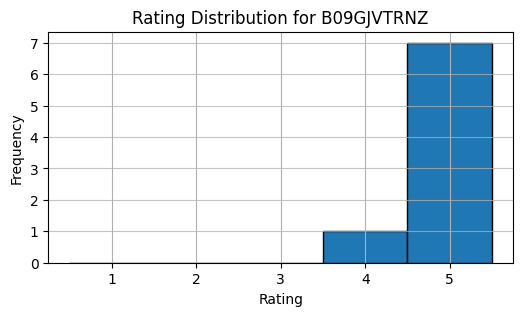


Rating distribution for Product ID: B0CVFKZ1LC


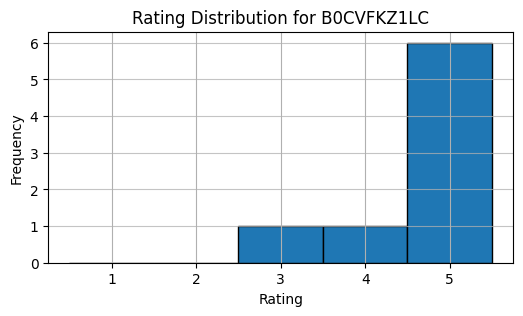


Rating distribution for Product ID: B0BG93TZ5N


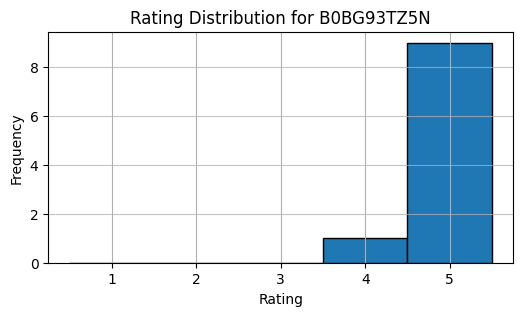


Rating distribution for Product ID: B07DD3WBYW


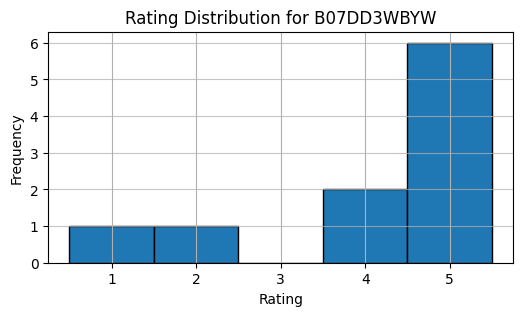


Rating distribution for Product ID: B0D4STD5ZC


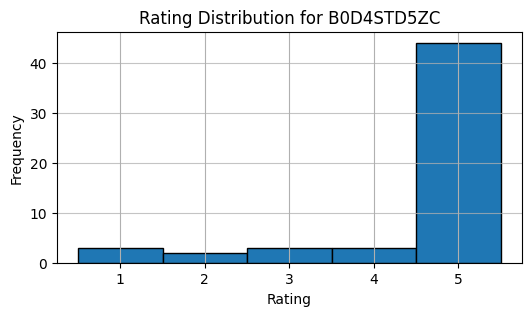


Rating distribution for Product ID: B0D4SX9RC6


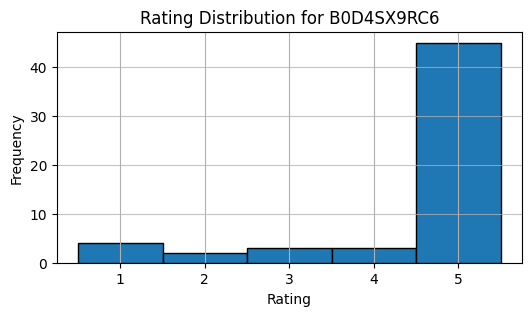


Rating distribution for Product ID: B07GWRCZQP



Rating distribution for Product ID: B01IOD7KB6



Rating distribution for Product ID: B0B44F1GGK


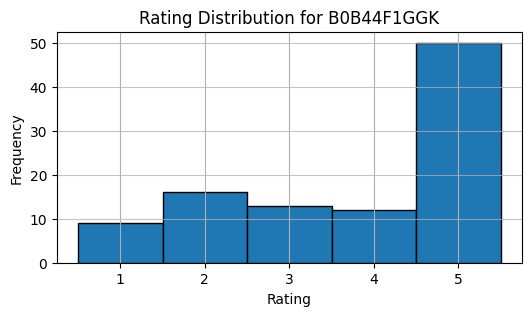


Rating distribution for Product ID: B09GK5JMHK


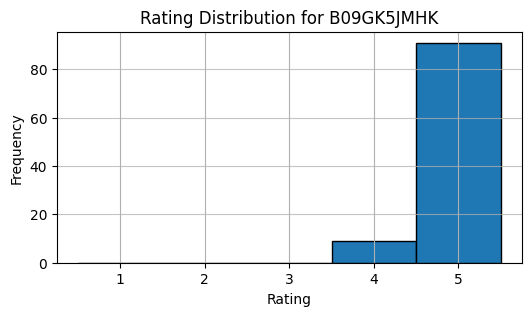


Rating distribution for Product ID: B097XX34SL


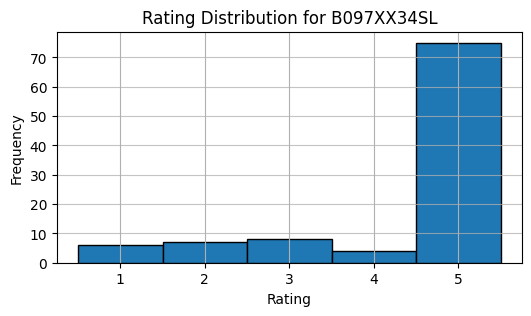


Rating distribution for Product ID: B099TLMRB6


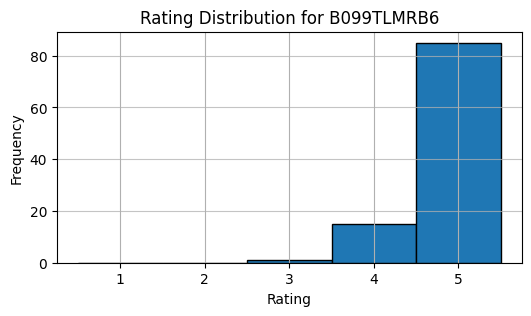


Rating distribution for Product ID: B0CXL4FQBK


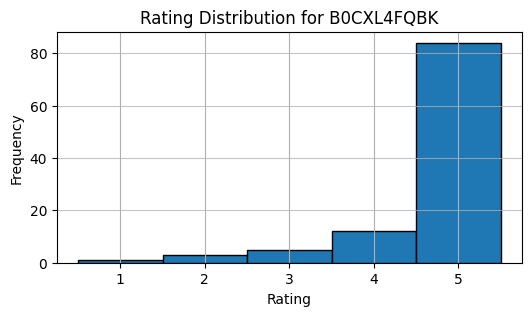


Rating distribution for Product ID: B09XXW54QG



Rating distribution for Product ID: B08X4YMTPM


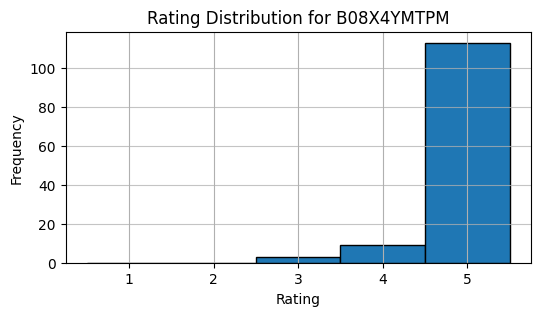

In [ ]:


# Group by 'product_id' and 'product_name' and count the number of reviews
review_counts_by_product = filtered_speakers_df.groupby(['product_id', 'product_name']).size().reset_index(name='number_of_reviews')

# Sort by the number of reviews in ascending order to see the least reviewed products first
review_counts_by_product = review_counts_by_product.sort_values(by='number_of_reviews', ascending=True)

# Display the distribution of review counts
print("Distribution of the number of reviews by Product ID and Product Name (sorted by lowest reviews):")
display(review_counts_by_product)

# Now, visualize the rating distribution for each product
print("\nRating Distribution by Product ID:")

# Get unique product IDs to iterate
unique_product_ids = review_counts_by_product['product_id'].tolist()

for product_id in unique_product_ids:
    print(f"\nRating distribution for Product ID: {product_id}")

    # Filter the original dataframe for the current product ID
    product_reviews = filtered_speakers_df[filtered_speakers_df['product_id'] == product_id]

    # Check if there are reviews for this product
    if not product_reviews.empty:
        # Create a histogram of ratings
        plt.figure(figsize=(6, 3)) # Adjust figure size as needed
        product_reviews['rating'].hist(bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], edgecolor='black')
        plt.title(f'Rating Distribution for {product_id}')
        plt.xlabel('Rating')
        plt.ylabel('Frequency')
        plt.xticks([1, 2, 3, 4, 5])
        plt.grid(axis='y', alpha=0.75)
        plt.show()
    else:
        print("No reviews found for this product ID in the filtered data.")

Found 15 unique products. Generating word clouds...


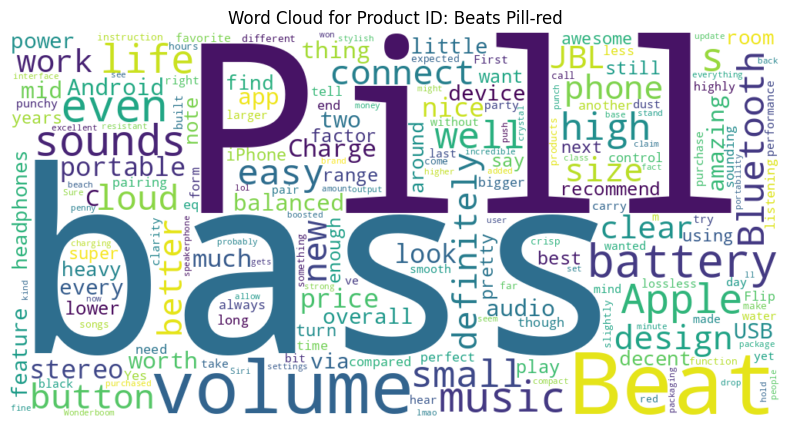

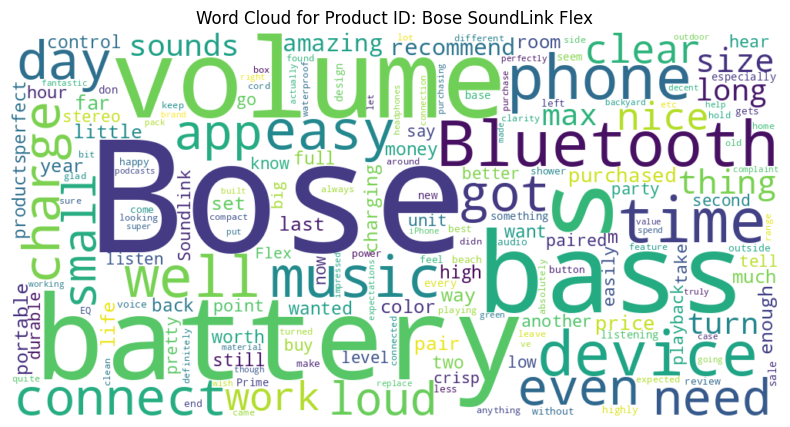

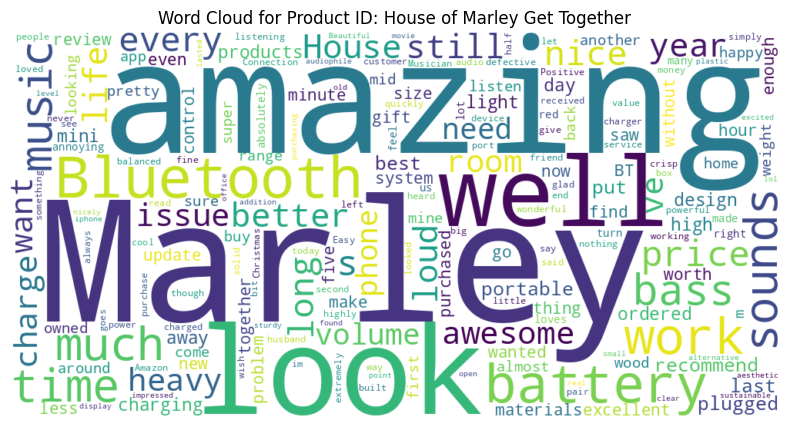

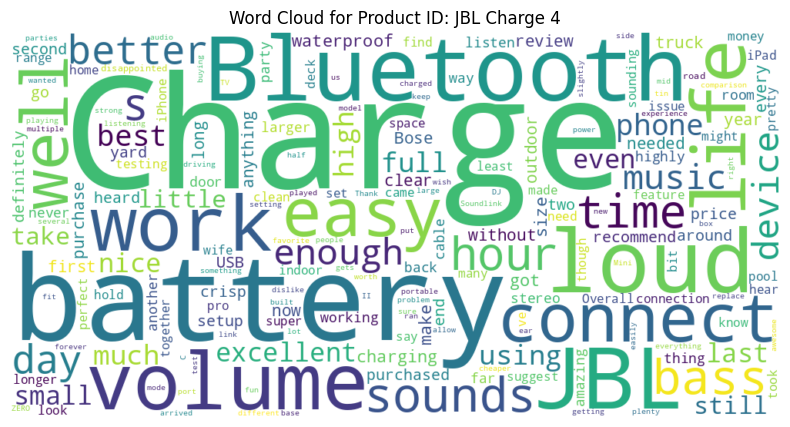

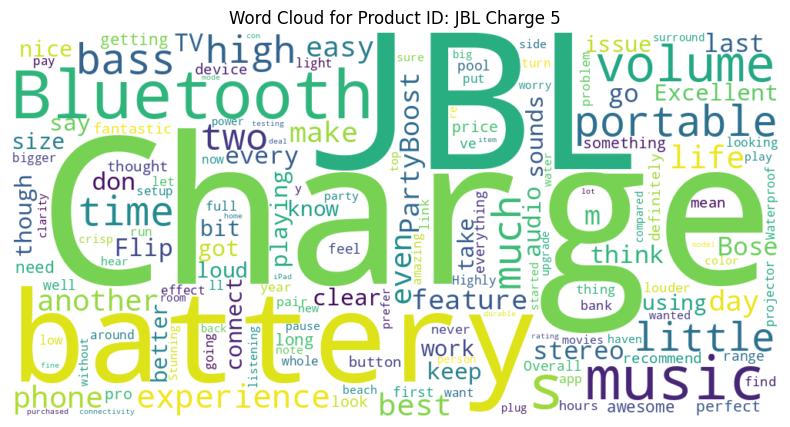

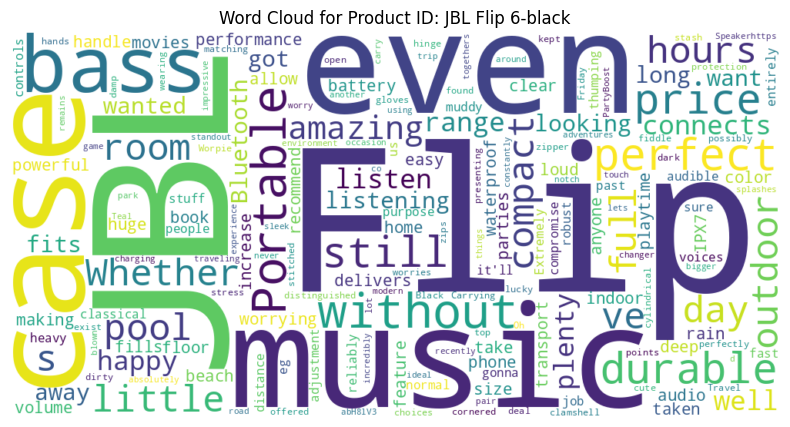

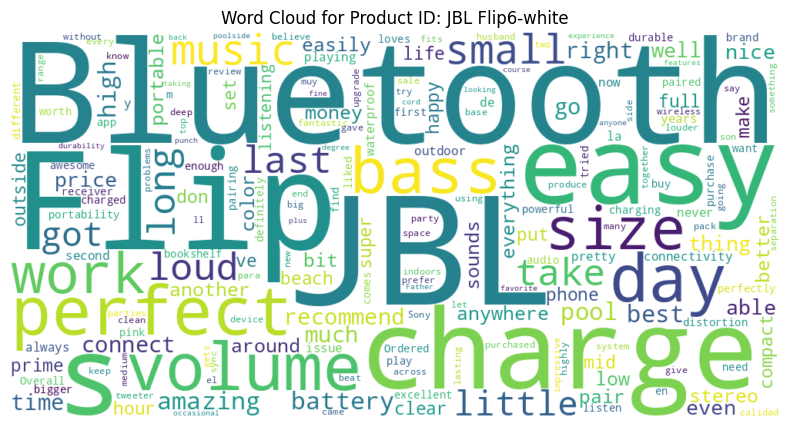

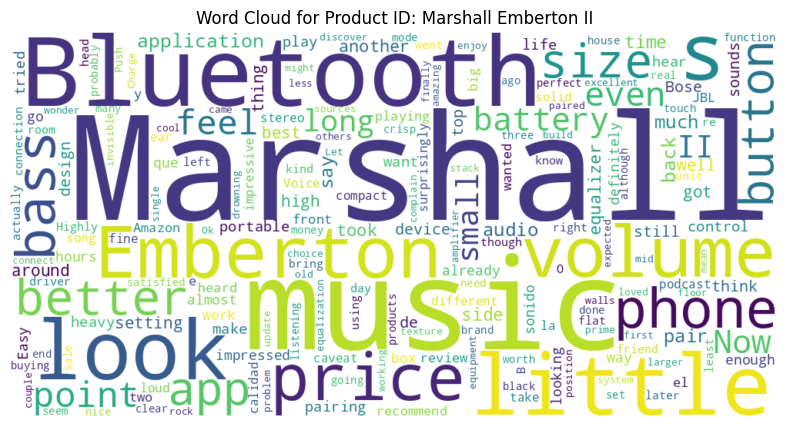

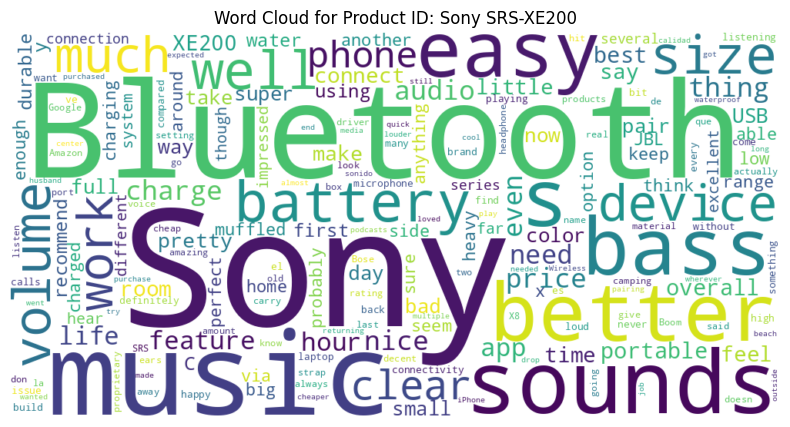

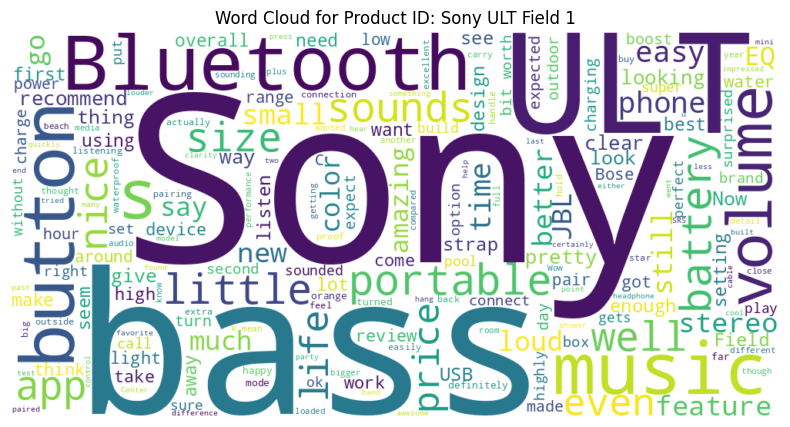

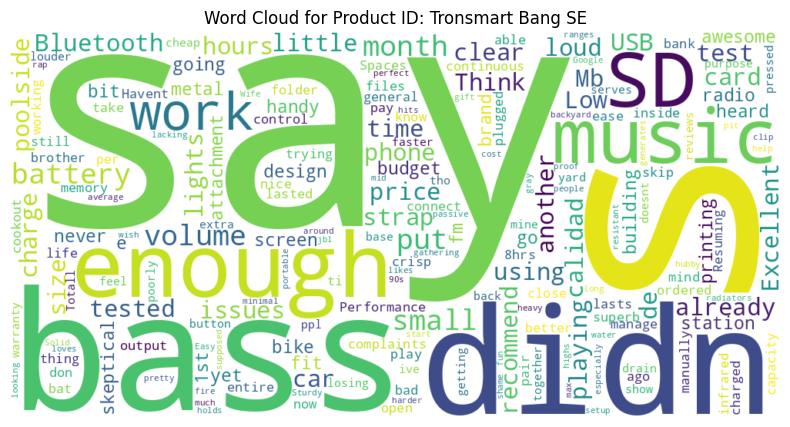

In [ ]:
def generate_wordclouds_by_product(df: pd.DataFrame):
    """
    Generates and displays a word cloud for the 'content' column of each unique 'product_id'.

    Args:
        df (pd.DataFrame): The input DataFrame containing 'product_id' and 'content' columns.
    """
    # Define common English stopwords to exclude from the word cloud

    # 1. Group the DataFrame by 'product_id'
    product_groups = filtered_speakers_df.groupby('short_name')

    print(f"Found {len(product_groups)} unique products. Generating word clouds...")

    # 2. Iterate through each group
    for prod_name, group in product_groups:
        try:
            # Drop any rows where 'content' is null for this specific product group
            cleaned_content_group = group.dropna(subset=['content'])

            if cleaned_content_group.empty:
                print(f"Skipping Product: {prod_name}. No valid content to analyze.")
                continue

            # 3. Concatenate all review content into a single string
            text_content = " ".join(cleaned_content_group['content'].astype(str))

            if not text_content.strip():
                 print(f"Skipping Product: {prod_name}. Content was empty after cleaning.")
                 continue

            # 4. Generate the WordCloud object
            wordcloud = WordCloud(
                width=1000,
                height=500,
                background_color='white',
                stopwords=custom_stopwords,
                min_font_size=10,
                collocations=False  # Set to False to prevent repeating words like 'product product'
            ).generate(text_content)

            # 5. Display the WordCloud image
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Word Cloud for Product ID: {prod_name}')
            plt.show()

        except Exception as e:
            print(f"An error occurred for product {prod_name}: {e}")

# 6. Call the function with your DataFrame
generate_wordclouds_by_product(filtered_speakers_df)


# TASK3: p3.s4.7
##Calcluate correlation matrix and create heatmap
this analysis will be on 'filtered_speakers_df'

In [ ]:
# 1. Select only numerical columns from the DataFrame.
# This step is crucial to avoid errors from non-numeric data.
numerical_df = filtered_speakers_df.select_dtypes(include=['number'])

# 2. Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# 3. Print the result
print("--- Correlation Matrix ---")
print(correlation_matrix)

--- Correlation Matrix ---
                 rating  is_verified  helpful_count     price
rating         1.000000     0.096611      -0.111650  0.142185
is_verified    0.096611     1.000000       0.029420  0.172324
helpful_count -0.111650     0.029420       1.000000  0.002173
price          0.142185     0.172324       0.002173  1.000000


In [ ]:
significant_correlations = correlation_matrix[(correlation_matrix >.5)| (correlation_matrix<-.5)]
print("Significant Correlations:")
print(significant_correlations)

Significant Correlations:
               rating  is_verified  helpful_count  price
rating            1.0          NaN            NaN    NaN
is_verified       NaN          1.0            NaN    NaN
helpful_count     NaN          NaN            1.0    NaN
price             NaN          NaN            NaN    1.0


In [ ]:
#create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

#Task 4 p3.s4.10 conduct sentiment analysis with textblob

In [ ]:
filtered_speakers_df['Polarity'] = filtered_speakers_df['content'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
filtered_speakers_df['Subjectivity'] = filtered_speakers_df['content'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
filtered_speakers_df.head()

product_id product_type                                       product_name  \
0  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   
1  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   
2  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   
3  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   
4  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   

        review_id                                              title  \
0  R1TIU27G892G8N  5.0 out of 5 stars Best for modern music; fine...   
1  R3UHPD69SUVF4D  5.0 out of 5 stars Incredible Sound and Perfor...   
2   R8ZPP4M7T18BO              5.0 out of 5 stars The Sound Is Great   
3  R3T9HSXO492VDG  5.0 out of 5 stars Incredible Sound and Durabi...   
4   RF4X9MUCFL4QZ       5.0 out of 5 stars Not too small Not too big   

                             author  rating  \
0  Glut & Lack: troublemaking twins       5   
1                              Seva       5   
2                          Michelle       5   
3                    Paola J Franco       5   
4                         Nikki Fox       5   

                                             content  \
0  Love this little speaker for the music I (and ...   
1  I recently bought the JBL Flip 6 Portable Blue...   
2  I'm so glad I bought this. I use it daily I ha...   
3  The sound quality is amazing for such a compac...   
4  These are not huge, but great for my sports pl...   

                     profile_id  is_verified  helpful_count  \
0  AEMU5GYR7E7YH5B64AKBUNZ5Y4PA            1             19   
1  AF2OOF3FJWVX65HP72K6CVPMONRA            1             14   
2  AHHSFRGEAFWTV24U7MFCK7V54P7Q            1              1   
3  AGIUPLMVY4PLRDFR6DCBYAG53LWQ            1              6   
4  AEP7HYGSBZ5Q2DII5UM2CWYXUQUA            1              1   

            product_attributes  price        country       date  \
0   Color: Blue, Style: Flip 6  99.95  United States 2025-01-14   
1   Color: Teal, Style: Flip 6  99.95  United States 2025-01-04   
2   Color: Blue, Style: Flip 6  99.95  United States 2025-04-16   
3  Color: White, Style: Flip 6  99.95  United States 2025-02-28   
4   Color: Blue, Style: Flip 6  99.95  United States 2025-04-17   

                                product_name_cleaned        short_name brand  \
0  JBL Flip 6 - Portable Bluetooth Speaker, power...  JBL Flip 6-black   JBL   
1  JBL Flip 6 - Portable Bluetooth Speaker, power...  JBL Flip 6-black   JBL   
2  JBL Flip 6 - Portable Bluetooth Speaker, power...  JBL Flip 6-black   JBL   
3  JBL Flip 6 - Portable Bluetooth Speaker, power...  JBL Flip 6-black   JBL   
4  JBL Flip 6 - Portable Bluetooth Speaker, power...  JBL Flip 6-black   JBL   

   Polarity  Subjectivity  
0  0.157667      0.606222  
1  0.324683      0.601508  
2  0.425595      0.593452  
3  0.262897      0.588095  
4  0.182500      0.662500

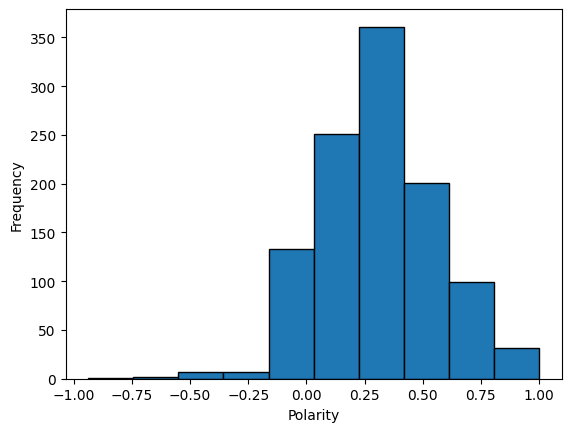

In [ ]:
#plot the histogram of overall polarity for all speakers in dataset
plt.hist(filtered_speakers_df['Polarity'], bins=10, edgecolor='black')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.show()

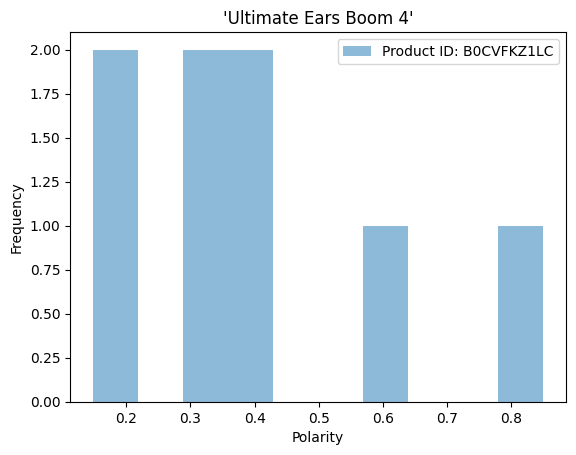

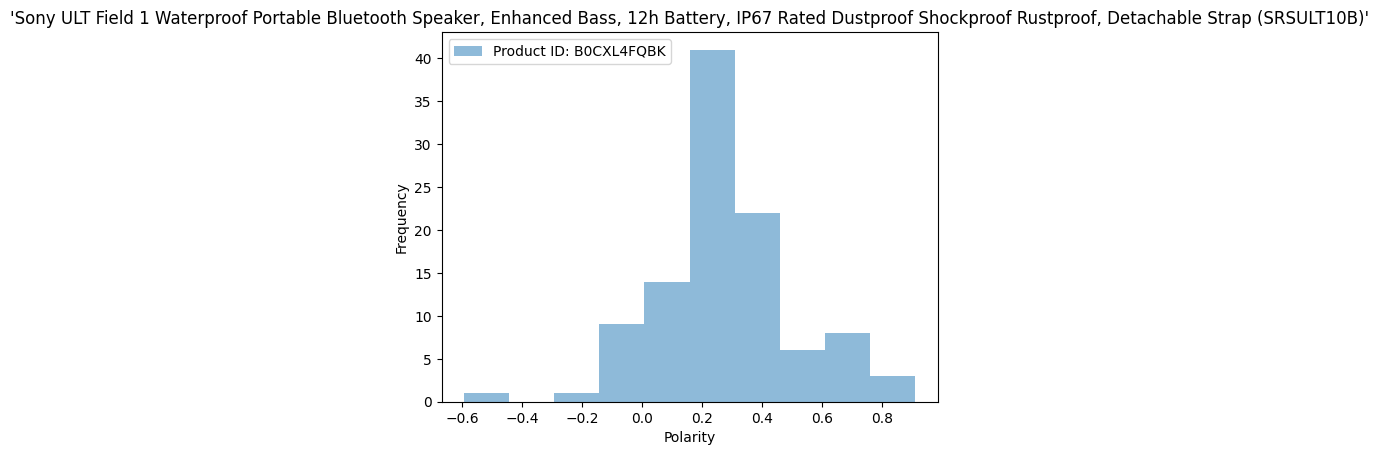

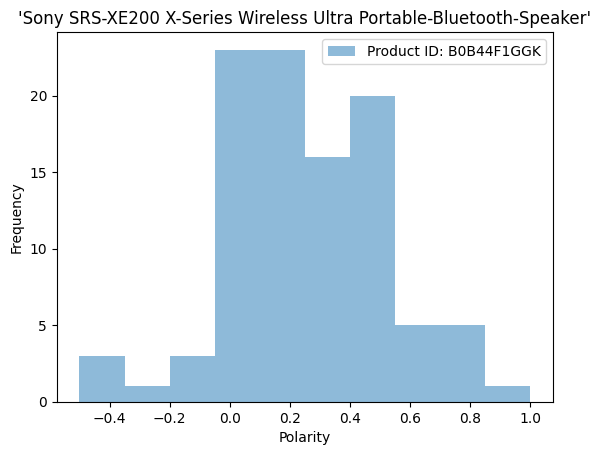

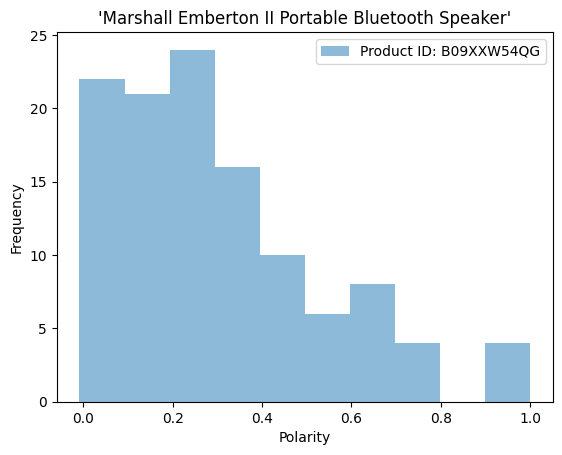

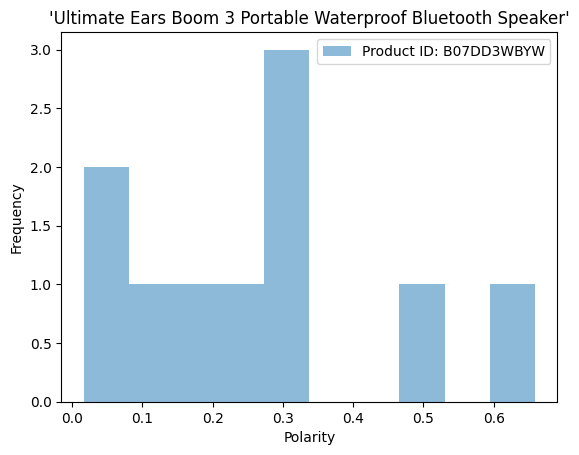

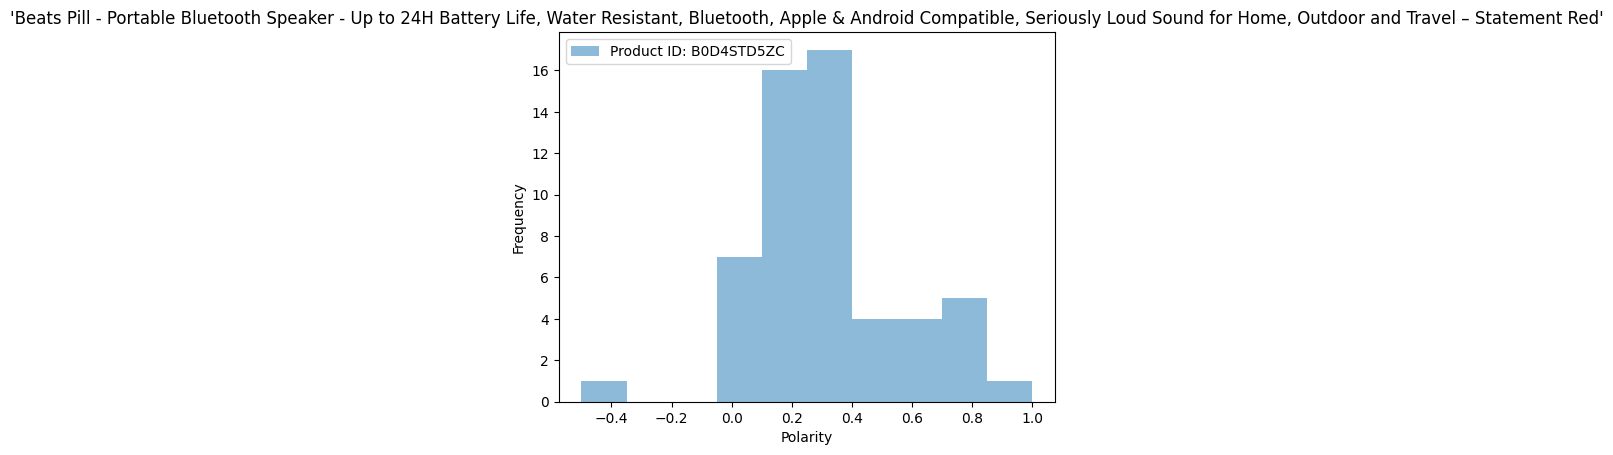

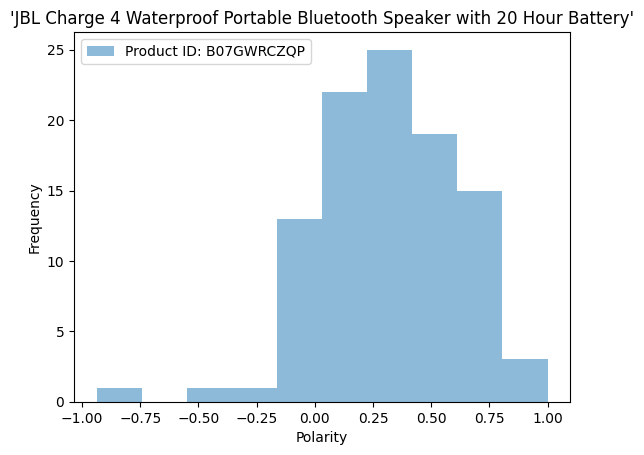

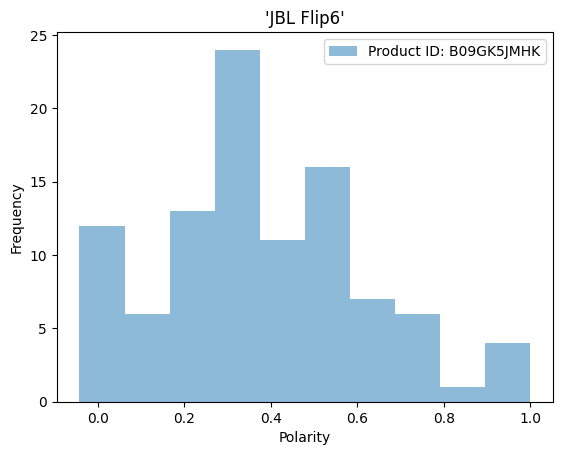

In [ ]:
#plot histogram for polarity, grouped by product id
for product_id in filtered_speakers_df['product_id'].unique():
  current_product_df = filtered_speakers_df[filtered_speakers_df['product_id'] == product_id]
  plt.hist(current_product_df['Polarity'], bins=10, alpha=0.5, label=f'Product ID: {product_id}')
  plt.xlabel('Polarity')
  plt.ylabel('Frequency')
  plt.legend()
  plt.title(current_product_df['product_name'].iloc[0])
  plt.show()


In [ ]:
filtered_speakers_df.columns

Index(['product_id', 'product_type', 'product_name', 'review_id', 'title',
       'author', 'rating', 'content', 'profile_id', 'is_verified',
       'helpful_count', 'product_attributes', 'price', 'country', 'date',
       'product_name_cleaned', 'short_name', 'brand', 'Polarity',
       'Subjectivity'],
      dtype='object')

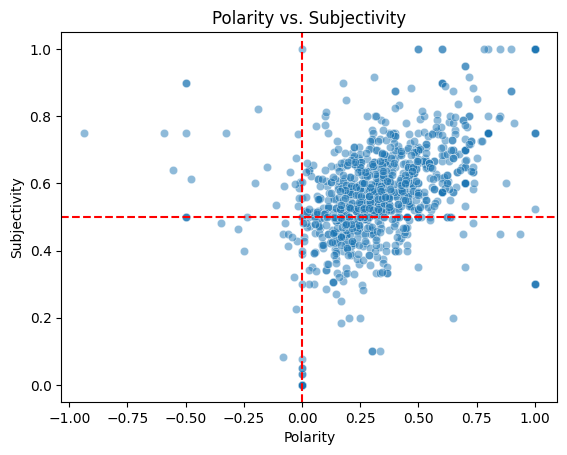

In [ ]:
#plot polarity vs subjectivity
sns.scatterplot(x='Polarity', y = 'Subjectivity', data=filtered_speakers_df, alpha=0.5)
plt.title('Polarity vs. Subjectivity')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.axvline(0, color='red', linestyle='--')
plt.axhline(.5, color='red', linestyle='--')
plt.show()

Sentiment
Positive    737
Neutral     342
Negative     15
Name: count, dtype: int64


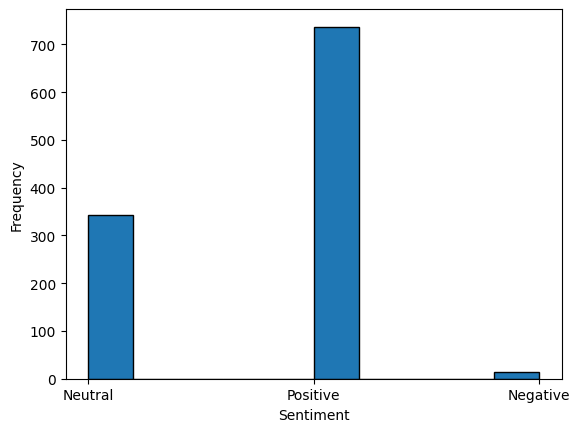

In [ ]:
#categorize sentiment
def categorize_sentiment(polarity):
    if polarity > .2:
        return 'Positive'
    elif polarity < -.2:
        return 'Negative'
    else:
      return 'Neutral'

filtered_speakers_df['Sentiment'] = filtered_speakers_df['Polarity'].apply(categorize_sentiment)
print(filtered_speakers_df['Sentiment'].value_counts())

#plot the categorized sentiment
plt.hist(filtered_speakers_df['Sentiment'], bins=10, edgecolor='black')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#generate word cloud for positive reviews
positive_reviews = filtered_speakers_df[filtered_speakers_df['Sentiment'] == 'Positive']
text_content = " ".join(positive_reviews['content'].astype(str))
wordcloud = WordCloud(width=1000, height=500, background_color='white', stopwords=custom_stopwords, min_font_size=10, collocations=False).generate(text_content)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

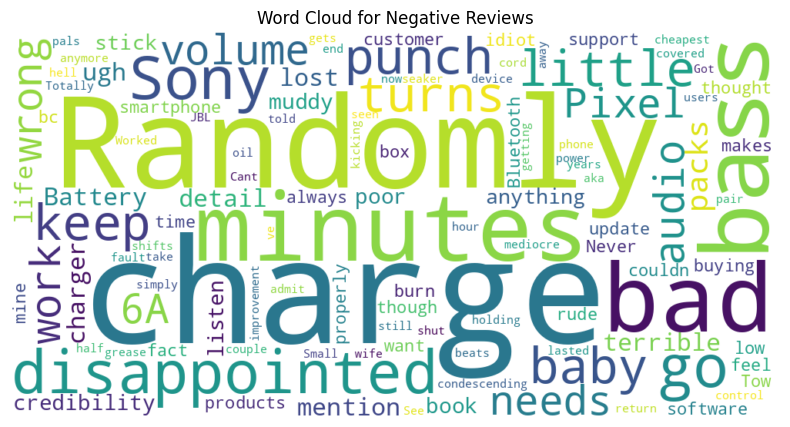

In [ ]:
#generate word cloud for negative reviews
positive_reviews = filtered_speakers_df[filtered_speakers_df['Sentiment'] == 'Negative']
text_content = " ".join(positive_reviews['content'].astype(str))
wordcloud = WordCloud(width=1000, height=500, background_color='white', stopwords=custom_stopwords, min_font_size=10, collocations=False).generate(text_content)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

# Task 5 use gemini for sentiment analysis


##api setup

In [ ]:
'''API_KEY=userdata.get('BBD_key_p3s4')
def generate():
    client = genai.Client(
    api_key=API_KEY,
    )
    model = "gemini-flash-latest"
    contents = [
        types.Content(
            role="user",
            parts=[
                types.Part.from_text(text="create python code to sort an array"),
            ],
        ),
    ]

    tools = [
        types.Tool(code_execution=types.ToolCodeExecution),
        types.Tool(googleSearch=types.GoogleSearch(
        )),
    ]
    generate_content_config = types.GenerateContentConfig(
        temperature=1.05,
        thinking_config = types.ThinkingConfig(
            thinking_budget=-1,
        ),
        image_config=types.ImageConfig(
            #image_size="1K",
        ),
        tools=tools
    )

    for chunk in client.models.generate_content_stream(
        model=model,
        contents=contents,
        config=generate_content_config,
    ):
        if (
            chunk.candidates is None
            or chunk.candidates[0].content is None
            or chunk.candidates[0].content.parts is None
        ):
            continue
        if chunk.candidates[0].content.parts[0].text:
            print(chunk.candidates[0].content.parts[0].text, end="")
        if chunk.candidates[0].content.parts[0].executable_code:
            print(chunk.candidates[0].content.parts[0].executable_code)
        if chunk.candidates[0].content.parts[0].code_execution_result:
            print(chunk.candidates[0].content.parts[0].code_execution_result)

if __name__ == "__main__":
    generate()
'''

'API_KEY=userdata.get(\'BBD_key_p3s4\')\ndef generate():\n    client = genai.Client(\n    api_key=API_KEY,\n    )\n    model = "gemini-flash-latest"\n    contents = [\n        types.Content(\n            role="user",\n            parts=[\n                types.Part.from_text(text="create python code to sort an array"),\n            ],\n        ),\n    ]\n\n    tools = [\n        types.Tool(code_execution=types.ToolCodeExecution),\n        types.Tool(googleSearch=types.GoogleSearch(\n        )),\n    ]\n    generate_content_config = types.GenerateContentConfig(\n        temperature=1.05,\n        thinking_config = types.ThinkingConfig(\n            thinking_budget=-1,\n        ),\n        image_config=types.ImageConfig(\n            #image_size="1K",\n        ),\n        tools=tools\n    )\n\n    for chunk in client.models.generate_content_stream(\n        model=model,\n        contents=contents,\n        config=generate_content_config,\n    ):\n        if (\n            chunk.candidate

In [ ]:
API_KEY=userdata.get('BBD_key_p3s4')

# Configure Gemini with your API key
genai.configure(api_key=API_KEY)

# Set up model configuration
generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 64,
  "max_output_tokens": 8192,
  "response_mime_type": "text/plain",
}

# Initialize the model
model = genai.GenerativeModel(
  model_name="gemini-2.5-flash",
  generation_config=generation_config
)


In [ ]:
#start chat session
chat_session = model.start_chat(
  history=[
    {
      "role": "user",
      "parts": [
        "You are a market research analyst specializing in consumer electronics.\\n",
      ],
    }
  ]
)

In [ ]:
# Test different prompts
response1 = chat_session.send_message("What are the key factors customers consider when buying headphones?")
print(response1.text)

response2 = chat_session.send_message("How would you analyze customer feedback about sound quality?")
print(response2.text)

As a market research analyst specializing in consumer electronics, I've observed that headphone purchasing decisions are rarely monolithic. They are a complex interplay of personal preferences, budget, intended use, and brand perception. Here are the key factors customers consider, often in a prioritized order based on their primary need:

---

### Key Factors Customers Consider When Buying Headphones:

1.  **Sound Quality:**
    *   **Clarity & Fidelity:** How crisp, clear, and true-to-source the audio sounds across the frequency spectrum (bass, mids, highs).
    *   **Bass Response:** For many, the depth and impact of the bass are crucial, especially for certain music genres (hip-hop, electronic).
    *   **Soundstage & Imaging:** How wide and immersive the sound feels, and how well instruments are separated and placed within that space (more critical for audiophiles).
    *   **Noise Cancellation (ANC) vs. Passive Isolation:** While distinct, the ability to block out external noise 

In [ ]:
def analyze_reviews(reviews, api_key, prompt_message):
    genai.configure(api_key=api_key)

    model = genai.GenerativeModel(
        model_name="gemini-2.5-flash",
        generation_config={
            "temperature": 1,
            "top_p": 0.95,
            "top_k": 64,
            "max_output_tokens": 8192,
            "response_mime_type": "text/plain",
        },
    )

    chat_session = model.start_chat(history=[])

    prompt = prompt_message + "\n\n".join(reviews)
    try:
        response = chat_session.send_message(prompt, request_options={'timeout': 1200})
        return response.text
    except Exception as e:
        # Return a more descriptive error message to avoid confusion
        return f"Error during API call: {type(e).__name__} - {e}"

## insights by review sets
such as most recent or randomly sampled reviews with gemin api

In [ ]:
# Sort the DataFrame by the 'date' column in ascending order
sorted_df = filtered_speakers_df.sort_values(by='date', ascending=True)

# Display the 'date' and 'content' columns from the sorted DataFrame
display(sorted_df[['date', 'content']])

date                                            content
932 2017-03-30  This is a great speaker! The sound is very cle...
924 2017-05-01  Very loud; great sound and great bass. Definit...
944 2017-05-10  LOVE the look .More or less same thin tinny so...
908 2017-06-26  Worth every penny! Incredible sound! Great bat...
933 2017-07-10  Great product and great company! You won't go ...
..         ...                                                ...
151 2025-04-09  Love the sound quality and that it is water pr...
2   2025-04-16  I'm so glad I bought this. I use it daily I ha...
20  2025-04-17  Bigger than expected, sounds quality is perfec...
4   2025-04-17  These are not huge, but great for my sports pl...
23  2025-04-18  Bought the Bose sound link and this one to com...

[1094 rows x 2 columns]

In [ ]:
# Try different ways to select reviews
reviews=filtered_speakers_df['content'].astype(str).tolist()
recent_reviews = sorted_df['content'].tail(50).tolist()
random_reviews = filtered_speakers_df['content'].sample(30).tolist()
#try different prompts

insights=analyze_reviews(reviews=reviews,
                         api_key=API_KEY,
                         prompt_message='Analyze the following reviews and summarize the key insights:')
print(insights)

Here's a summary of key insights from the provided reviews, categorized by common themes and specific product observations:

**Overall Positive Trends:**

*   **Impressive Sound for Size:** Across almost all brands, reviewers are consistently surprised by the powerful sound, volume, and bass output from relatively compact and portable speakers.
*   **Strong Bass Emphasis:** Many speakers, particularly JBL, Beats Pill, and Sony ULT Field 1, are praised for deep, punchy, and impactful bass, making them excellent for modern genres like EDM and hip-hop.
*   **Durability & Water Resistance:** IPX7/IP67 ratings are highly valued, with many anecdotes of speakers surviving splashes, rain, drops, and even accidental submersion. This makes them ideal for outdoor and adventurous use.
*   **Easy Connectivity:** Bluetooth pairing is generally described as fast, seamless, and reliable across brands, often with automatic reconnection to previously paired devices.
*   **Portability:** Most speakers ar

In [ ]:
prompt='Analyze the following reviews and summarize the key insights:'

basic_prompts = [
    "Summarize the main themes in these reviews:",
    "What are the most frequently mentioned features in these reviews?",
    "Identify the common positive and negative points in these reviews:"
]

In [ ]:
# Check unique products in your dataset
unique_products = filtered_speakers_df['product_name'].unique()
print("Products in dataset:")
for product in unique_products:
    print(f"- {product}")

Products in dataset:
- 'JBL Flip 6 - Portable Bluetooth Speaker, powerful sound and deep bass, IPX7 waterproof, 12 hours of playtime, JBL PartyBoost for multiple speaker pairing for home, outdoor and travel (Black)'
- 'JBL Charge 5 - Portable Bluetooth Speaker with IP67 Waterproof and USB Charge Out'
- 'Ultimate Ears Boom 4'
- 'Sony ULT Field 1 Waterproof Portable Bluetooth Speaker, Enhanced Bass, 12h Battery, IP67 Rated Dustproof Shockproof Rustproof, Detachable Strap (SRSULT10B)'
- 'Beats Pill'
- 'Sony SRS-XE200 X-Series Wireless Ultra Portable-Bluetooth-Speaker'
- 'Tronsmart Bang SE Portable Bluetooth Speaker, Colorful LED and 40W Wireless Stereo to Infuse Your Party, Ultra Lightweight Portable Design and IPX6 Waterproof, Suitable for Party/Outdoor/Travel'
- 'Marshall Emberton II Portable Bluetooth Speaker'
- 'Ultimate Ears Boom 3 Portable Waterproof Bluetooth Speaker'
- 'House of Marley - Get Together Bluetooth Portable Bluetooth Speaker and Audio System - 3.5 Woofer & 1 Tweeters, 

### checking for potential data entry error
### potential error:
prod ids:B09GJVTRNZ & B09GK5JMHK, both have product name including 'JBL Flip6'<br>
**later included prodIDs for beats pill entries due to similiar issue
### explanation of resolution
product is the same but different colors and thus have different ASIN/product_ids

<mark>
B09GK5JMHK=jbl flip 6-white <br>

<mark>
B09GJVTRNZ=jbl flip 6-black <br>

<mark>
B0D4SX9RC6=beats pill-black<br>

<mark>
B0D4STD5ZC= beats pill-red



In [ ]:
# Filter the DataFrame to find records containing 'JBL Flip' in the product_name
jbl_flip_products = filtered_speakers_df[
    filtered_speakers_df['product_name'].str.contains('JBL Flip', case=False, na=False)
]

# Select only the 'product_id' and 'product_name' fields for the results
jbl_flip_products_subset = jbl_flip_products[['product_id', 'product_name']]

# Display the resulting DataFrame
print("Records containing 'JBL Flip' in product_name:")
#display(jbl_flip_products_subset.drop_duplicates())
display(jbl_flip_products_subset)

Records containing 'JBL Flip' in product_name:


product_id                                       product_name
0     B09GJVTRNZ  'JBL Flip 6 - Portable Bluetooth Speaker, powe...
1     B09GJVTRNZ  'JBL Flip 6 - Portable Bluetooth Speaker, powe...
2     B09GJVTRNZ  'JBL Flip 6 - Portable Bluetooth Speaker, powe...
3     B09GJVTRNZ  'JBL Flip 6 - Portable Bluetooth Speaker, powe...
4     B09GJVTRNZ  'JBL Flip 6 - Portable Bluetooth Speaker, powe...
...          ...                                                ...
1716  B09GK5JMHK                                        'JBL Flip6'
1717  B09GK5JMHK                                        'JBL Flip6'
1718  B09GK5JMHK                                        'JBL Flip6'
1719  B09GK5JMHK                                        'JBL Flip6'
1720  B09GK5JMHK                                        'JBL Flip6'

[108 rows x 2 columns]

In [ ]:
# Filter the DataFrame to find records containing 'Beats Pill' in the product_name
beats_pill_products = filtered_speakers_df[
    filtered_speakers_df['product_name'].str.contains('Beats Pill', case=False, na=False)
]

# Select only the 'product_id' and 'product_name' fields for the results
beats_pill_products_subset = beats_pill_products[['product_id', 'product_name']]

# Display the resulting DataFrame
print("Records containing 'Beats Pill' in product_name:")
#display(beats_pill_products_subset.drop_duplicates())
display(beats_pill_products_subset)

Records containing 'Beats Pill' in product_name:


product_id                                       product_name
367   B0D4SX9RC6                                       'Beats Pill'
368   B0D4SX9RC6                                       'Beats Pill'
369   B0D4SX9RC6                                       'Beats Pill'
370   B0D4SX9RC6                                       'Beats Pill'
371   B0D4SX9RC6                                       'Beats Pill'
...          ...                                                ...
1415  B0D4STD5ZC  'Beats Pill - Portable Bluetooth Speaker - Up ...
1416  B0D4STD5ZC  'Beats Pill - Portable Bluetooth Speaker - Up ...
1417  B0D4STD5ZC  'Beats Pill - Portable Bluetooth Speaker - Up ...
1418  B0D4STD5ZC  'Beats Pill - Portable Bluetooth Speaker - Up ...
1419  B0D4STD5ZC  'Beats Pill - Portable Bluetooth Speaker - Up ...

[112 rows x 2 columns]

### create mappings for long prod names to short prod name and brand name

In [ ]:
# #create mappings
# product_mapping = {
#     'JBL Flip 6 - Portable Bluetooth Speaker, powerful sound and deep bass, IPX7 waterproof, 12 hours of playtime, JBL PartyBoost for multiple speaker pairing for home, outdoor and travel (Black)':{
#         'short_name': 'JBL Flip 6-black',
#         'brand': 'JBL'
#     },
#     'JBL Charge 5 - Portable Bluetooth Speaker with IP67 Waterproof and USB Charge Out':{
#         'short_name': 'JBL Charge 5',
#         'brand': 'JBL'
#     },
#     'Ultimate Ears Boom 4':{
#         'short_name': 'Ultimate Ears Boom 4',
#         'brand': 'Ultimate Ears'
#     },
#     'Sony ULT Field 1 Waterproof Portable Bluetooth Speaker, Enhanced Bass, 12h Battery, IP67 Rated Dustproof Shockproof Rustproof, Detachable Strap (SRSULT10B)':{
#         'short_name': 'Sony ULT Field 1',
#         'brand': 'Sony'
#     },
#     'Beats Pill':{
#         'short_name': 'Beats Pill-black',
#         'brand': 'Beats'
#     },
#     'Sony SRS-XE200 X-Series Wireless Ultra Portable-Bluetooth-Speaker':{
#         'short_name': 'Sony SRS-XE200',
#         'brand': 'Sony'
#     },
#     'Tronsmart Bang SE Portable Bluetooth Speaker, Colorful LED and 40W Wireless Stereo to Infuse Your Party, Ultra Lightweight Portable Design and IPX6 Waterproof, Suitable for Party/Outdoor/Travel':{
#         'short_name': 'Tronsmart Bang SE',
#         'brand': 'Tronsmart'
#     },
#     'Marshall Emberton II Portable Bluetooth Speaker':{
#         'short_name': 'Marshall Emberton II',
#         'brand': 'Marshall'
#     },
#    'Ultimate Ears Boom 3 Portable Waterproof Bluetooth Speaker':{
#         'short_name': 'Ultimate Ears Boom 3',
#         'brand': 'Ultimate Ears'
#     },

#      'House of Marley - Get Together Bluetooth Portable Bluetooth Speaker and Audio System - 3.5 Woofer & 1 Tweeters, 30m Wireless Range, 8 Hour Playtime, Sustainably':{
#          'short_name': 'House of Marley Get Together',
#          'brand': 'House of Marley'
#      },
#      'Monster S320 Bluetooth Speaker, 40W True Wireless,360° Stereo Sound Effect,IPX7 Waterproof, 32 Hour Playing Time,Suitable for Outdoor Portable Speaker, Black':{
#          'short_name': 'Monster S320',
#          'brand': 'Monster'
#      },
#      'Beats Pill - Portable Bluetooth Speaker - Up to 24H Battery Life, Water Resistant, Bluetooth, Apple & Android Compatible, Seriously Loud Sound for Home, Outdoor and Travel – Statement Red':{
#          'short_name': 'Beats Pill-red',
#          'brand': 'Beats'
#      },
#     'Bose SoundLink Flex Bluetooth Portable Speaker, Wireless Waterproof Speaker for Outdoor Travel - White':{
#         'short_name': 'Bose SoundLink Flex',
#         'brand': 'Bose'
#     },
#     'JBL Charge 4 Waterproof Portable Bluetooth Speaker with 20 Hour Battery':{
#         'short_name': 'JBL Charge 4',
#         'brand': 'JBL'
#     },
#      'JBL Flip6':{
#          'short_name': 'JBL Flip6-white',
#          'brand': 'JBL'
#      }
# }

# def clean_product_info(df, mapping):
#   df['product_name_cleaned'] = df['product_name'].str.strip("'")
#   # #delete the 'product_name' column
#   # df.drop(columns=df['product_name'], inplace=True)

#   #create new columns using the mapping
#   df['short_name'] = df['product_name_cleaned'].map({k:v['short_name'] for k, v in mapping.items()})
#   df['brand'] = df['product_name_cleaned'].map({k:v['brand'] for k, v in mapping.items()})
#   #handle any products not in mapping
#   df['short_name'] = df['short_name'].fillna(df['product_name']) # Changed 'Product Name' to 'product_name'
#   df['brand'] = df['brand'].fillna('Unknown')
#   return df

In [ ]:
current_df=filtered_speakers_df.copy()
current_df=clean_product_info(current_df, product_mapping)
filtered_speakers_df=current_df

In [ ]:
filtered_speakers_df.head()

product_id product_type                                       product_name  \
0  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   
1  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   
2  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   
3  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   
4  B09GJVTRNZ    'speaker'  'JBL Flip 6 - Portable Bluetooth Speaker, powe...   

        review_id                                              title  \
0  R1TIU27G892G8N  5.0 out of 5 stars Best for modern music; fine...   
1  R3UHPD69SUVF4D  5.0 out of 5 stars Incredible Sound and Perfor...   
2   R8ZPP4M7T18BO              5.0 out of 5 stars The Sound Is Great   
3  R3T9HSXO492VDG  5.0 out of 5 stars Incredible Sound and Durabi...   
4   RF4X9MUCFL4QZ       5.0 out of 5 stars Not too small Not too big   

                             author  rating  \
0  Glut & Lack: troublemaking twins       5   
1                              Seva       5   
2                          Michelle       5   
3                    Paola J Franco       5   
4                         Nikki Fox       5   

                                             content  \
0  Love this little speaker for the music I (and ...   
1  I recently bought the JBL Flip 6 Portable Blue...   
2  I'm so glad I bought this. I use it daily I ha...   
3  The sound quality is amazing for such a compac...   
4  These are not huge, but great for my sports pl...   

                     profile_id  is_verified  ...  \
0  AEMU5GYR7E7YH5B64AKBUNZ5Y4PA            1  ...   
1  AF2OOF3FJWVX65HP72K6CVPMONRA            1  ...   
2  AHHSFRGEAFWTV24U7MFCK7V54P7Q            1  ...   
3  AGIUPLMVY4PLRDFR6DCBYAG53LWQ            1  ...   
4  AEP7HYGSBZ5Q2DII5UM2CWYXUQUA            1  ...   

            product_attributes  price        country       date  \
0   Color: Blue, Style: Flip 6  99.95  United States 2025-01-14   
1   Color: Teal, Style: Flip 6  99.95  United States 2025-01-04   
2   Color: Blue, Style: Flip 6  99.95  United States 2025-04-16   
3  Color: White, Style: Flip 6  99.95  United States 2025-02-28   
4   Color: Blue, Style: Flip 6  99.95  United States 2025-04-17   

                                product_name_cleaned        short_name brand  \
0  JBL Flip 6 - Portable Bluetooth Speaker, power...  JBL Flip 6-black   JBL   
1  JBL Flip 6 - Portable Bluetooth Speaker, power...  JBL Flip 6-black   JBL   
2  JBL Flip 6 - Portable Bluetooth Speaker, power...  JBL Flip 6-black   JBL   
3  JBL Flip 6 - Portable Bluetooth Speaker, power...  JBL Flip 6-black   JBL   
4  JBL Flip 6 - Portable Bluetooth Speaker, power...  JBL Flip 6-black   JBL   

   Polarity  Subjectivity  Sentiment  
0  0.157667      0.606222    Neutral  
1  0.324683      0.601508   Positive  
2  0.425595      0.593452   Positive  
3  0.262897      0.588095   Positive  
4  0.182500      0.662500    Neutral  

[5 rows x 21 columns]

##individual Basic product insights
analysis w/ gemini

In [ ]:
for product in filtered_speakers_df['short_name'].unique():
  print(product)

JBL Flip 6-black
JBL Charge 5
Ultimate Ears Boom 4
Sony ULT Field 1
Beats Pill-black
Sony SRS-XE200
Tronsmart Bang SE
Marshall Emberton II
Ultimate Ears Boom 3
House of Marley Get Together
'Monster S320 Bluetooth Speaker, 40W True Wireless,360° Stereo Sound Effect,IPX7 Waterproof, 32 Hour Playing Time,Suitable for Outdoor Portable Speaker,Black.'
Beats Pill-red
Bose SoundLink Flex
JBL Charge 4
JBL Flip6-white


In [ ]:
def analyze_basic_product(reviews, product_name):
    prompt_message = f"""Analyze these reviews for {product_name}:
    1. What are the top 3 most mentioned features?
    2. What do customers love most about this product?
    3. What are the most common complaints?

    Please provide specific examples from the reviews."""

    return analyze_reviews(reviews, API_KEY, prompt_message)




In [ ]:
# Example: Analyze a single product
product_reviews = filtered_speakers_df[filtered_speakers_df['short_name'] == 'Beats Pill-red']['content'].tolist()[:30]
basic_insights = analyze_basic_product(product_reviews, 'Beats Pill-red')
print(basic_insights)

Here's an analysis of the reviews for the Beats Pill-red:

---

### 1. Top 3 Most Mentioned Features:

1.  **Sound Quality (especially Bass and Clarity):** This is overwhelmingly the most mentioned feature, with nearly every review highlighting it. Customers consistently praise its clear audio, strong bass, and balanced sound for its size.
    *   **Specific examples:**
        *   "The sound quality of this speaker is really great for its size, living up to the Beats name, filling the room with punchy bass and crystal clear sound."
        *   "Bass is great. Clarity is great."
        *   "The sound quality is amazing with great bass and clear vocals."
        *   "The audio is crystal clear, with balanced mids and highs. The bass is punchy yet smooth..."
        *   "This 2 pound speaker sounds insane for its size."
        *   "it is Brighter, crisper and deeper bass at 50% volume and lower."
        *   "This speaker has incredible sound and bass for its size."

2.  **Apple Ecosys

## Individual Product Sentiment analysis
w/ Gemini

In [ ]:
def analyze_sentiment_patterns(reviews, sentiment_category, product_name=None, brand=None):
    target_entity = ""
    if product_name and brand:
        target_entity = f"product '{product_name}' (Brand: {brand})"
    elif product_name:
        target_entity = f"product '{product_name}'"
    elif brand:
        target_entity = f"brand '{brand}'"
    else:
        raise ValueError("Either 'product_name' or 'brand' must be provided for sentiment analysis.")

    prompt_message = f"""Analyze these {sentiment_category.lower()} reviews for {target_entity}:
    1. What specific aspects create {sentiment_category.lower()} reactions?
    2. Identify common phrases or descriptions used
    3. Note any comparisons with competitor products
    4. Find unexpected or unique feedback

    Support your analysis with specific examples."""

    return analyze_reviews(reviews, API_KEY, prompt_message)

In [ ]:
filtered_speakers_df

product_id product_type  \
0     B09GJVTRNZ    'speaker'   
1     B09GJVTRNZ    'speaker'   
2     B09GJVTRNZ    'speaker'   
3     B09GJVTRNZ    'speaker'   
4     B09GJVTRNZ    'speaker'   
...          ...          ...   
1716  B09GK5JMHK    'speaker'   
1717  B09GK5JMHK    'speaker'   
1718  B09GK5JMHK    'speaker'   
1719  B09GK5JMHK    'speaker'   
1720  B09GK5JMHK    'speaker'   

                                           product_name       review_id  \
0     'JBL Flip 6 - Portable Bluetooth Speaker, powe...  R1TIU27G892G8N   
1     'JBL Flip 6 - Portable Bluetooth Speaker, powe...  R3UHPD69SUVF4D   
2     'JBL Flip 6 - Portable Bluetooth Speaker, powe...   R8ZPP4M7T18BO   
3     'JBL Flip 6 - Portable Bluetooth Speaker, powe...  R3T9HSXO492VDG   
4     'JBL Flip 6 - Portable Bluetooth Speaker, powe...   RF4X9MUCFL4QZ   
...                                                 ...             ...   
1716                                        'JBL Flip6'  R1QIWOTDHCS5T2   
1717                                        'JBL Flip6'  R34LI3JPW9YH8U   
1718                                        'JBL Flip6'  R14AO84846O9JF   
1719                                        'JBL Flip6'   RQRDCBIMLCG91   
1720                                        'JBL Flip6'  R1XY43NDBG07OR   

                                                  title  \
0     5.0 out of 5 stars Best for modern music; fine...   
1     5.0 out of 5 stars Incredible Sound and Perfor...   
2                 5.0 out of 5 stars The Sound Is Great   
3     5.0 out of 5 stars Incredible Sound and Durabi...   
4          5.0 out of 5 stars Not too small Not too big   
...                                                 ...   
1716                        5.0 out of 5 stars Must buy   
1717                5.0 out of 5 stars Sound is awesome   
1718                   5.0 out of 5 stars Amazing sound   
1719               5.0 out of 5 stars wonderful product   
1720                 5.0 out of 5 stars Amazing Sound!!   

                                author  rating  \
0     Glut & Lack: troublemaking twins       5   
1                                 Seva       5   
2                             Michelle       5   
3                       Paola J Franco       5   
4                            Nikki Fox       5   
...                                ...     ...   
1716                     samuel miller       5   
1717                   Immaculate Kean       5   
1718                               Jim       5   
1719                      jaybeebaybee       5   
1720                    Dustin Wireman       5   

                                                content  \
0     Love this little speaker for the music I (and ...   
1     I recently bought the JBL Flip 6 Portable Blue...   
2     I'm so glad I bought this. I use it daily I ha...   
3     The sound quality is amazing for such a compac...   
4     These are not huge, but great for my sports pl...   
...                                                 ...   
1716  Got a new one for outside building decks kayak...   
1717  I love this speaker it has enough volume and h...   
1718  Just wow! Paired with my phone seamlessly and ...   
1719  JBL consistently makes banger products, very h...   
1720  Arrived quickly, and the speaker has an amazin...   

                        profile_id  is_verified  ...  \
0     AEMU5GYR7E7YH5B64AKBUNZ5Y4PA            1  ...   
1     AF2OOF3FJWVX65HP72K6CVPMONRA            1  ...   
2     AHHSFRGEAFWTV24U7MFCK7V54P7Q            1  ...   
3     AGIUPLMVY4PLRDFR6DCBYAG53LWQ            1  ...   
4     AEP7HYGSBZ5Q2DII5UM2CWYXUQUA            1  ...   
...                            ...          ...  ...   
1716  AESSLYBNM2ITQYGX2DMF25BJYT4A            1  ...   
1717  AEB33EEXZRXPVB4WJF666HFGIXNA            1  ...   
1718  AEK5SLVW3JB5HJ5V4KU3ZWUQWS3Q            1  ...   
1719  AGDQRW7AMVAPZD6C2UFYHTFBGSIA            1  ...   
1720  AHHZADW5EK3QHAM6N3LVVWFMJ3FA            1  ...   

               p

In [ ]:
positive_reviews = filtered_speakers_df[
    (filtered_speakers_df['short_name'] == 'JBL Flip6-white') &
    (filtered_speakers_df['Sentiment'] == 'Positive')
]['content'].tolist()[:5]

In [ ]:
# Create a dictionary to store positive reviews by brand
positive_reviews_by_brand = {}

# Get all unique brands from the filtered_speakers_df
unique_brands = filtered_speakers_df['brand'].unique()

# Loop through each unique brand
for brand_name in unique_brands:
    # Filter the DataFrame for the current brand and positive sentiment
    brand_positive_reviews = filtered_speakers_df[
        (filtered_speakers_df['brand'] == brand_name) &
        (filtered_speakers_df['Sentiment'] == 'Positive')
    ]['content'].tolist()#[:30] # Limit to first 30 reviews

    # Store the list in the dictionary if there are reviews
    if brand_positive_reviews:
        positive_reviews_by_brand[brand_name] = brand_positive_reviews

# Display the brands for which positive reviews were found and the count of reviews for each
print("Positive Reviews by Brand:")
for brand, reviews in positive_reviews_by_brand.items():
    print(f"Brand: {brand}, Number of Positive Reviews: {len(reviews)}")


Positive Reviews by Brand:
Brand: JBL, Number of Positive Reviews: 240
Brand: Ultimate Ears, Number of Positive Reviews: 12
Brand: Sony, Number of Positive Reviews: 123
Brand: Beats, Number of Positive Reviews: 75
Brand: Tronsmart, Number of Positive Reviews: 6
Brand: Marshall, Number of Positive Reviews: 71
Brand: House of Marley, Number of Positive Reviews: 75
Brand: Unknown, Number of Positive Reviews: 66
Brand: Bose, Number of Positive Reviews: 69


<mark> Customer Sentiment analysis- key strengths

In [ ]:
# Loop through the positive_reviews_by_brand dictionary
for brand_name, reviews_list in positive_reviews_by_brand.items():
    print(f"\n--- Analyzing Positive Reviews for Brand: {brand_name} ---")
    if reviews_list:
        # Limit to 30 reviews for analysis if the list is longer
        reviews_for_analysis = reviews_list[:30]
        insights = analyze_sentiment_patterns(
            reviews_for_analysis,
            'Positive',
            brand=brand_name
        )
        print(insights)
    else:
        print(f"No positive reviews found for {brand_name}.")


--- Analyzing Positive Reviews for Brand: JBL ---
Here's an analysis of the positive JBL reviews:

### 1. What specific aspects create positive reactions?

The positive reactions primarily stem from a strong combination of **audio performance, rugged design, practical features, and user-friendliness.**

*   **Superior Sound Quality:** This is the most frequently praised aspect, often described with enthusiasm.
    *   **Powerful Volume & Loudness:** Reviewers consistently highlight how loud the speakers can get, even for their size. "Surprisingly loud for its size" (Flip 6 review), "insane volume. I rarely have it over 50%, but in the event where I need it louder, I turn it up. I once had music filling a whole event center" (Charge 5 detailed review). "BIG sound" (Generic review).
    *   **Deep, Punchy Bass:** The bass performance is a major standout. "Deep bass that fills the room" (Flip 6 review), "strong bass without being overwhelming" (Charge 5 gift review), "The bass is DEEP. I

In [ ]:
# Create a dictionary to store negative reviews by brand
negative_reviews_by_brand = {}

# Get all unique brands from the filtered_speakers_df
unique_brands = filtered_speakers_df['brand'].unique()

# Loop through each unique brand
for brand_name in unique_brands:
    # Filter the DataFrame for the current brand and negative sentiment
    brand_negative_reviews = filtered_speakers_df[
        (filtered_speakers_df['brand'] == brand_name) &
        (filtered_speakers_df['Sentiment'] == 'Negative')
    ]['content'].tolist()#[:30] # Limit to first 30 reviews

    # Store the list in the dictionary if there are reviews
    if brand_negative_reviews:
        negative_reviews_by_brand[brand_name] = brand_negative_reviews

# Display the brands for which negative reviews were found and the count of reviews for each
print("Negative Reviews by Brand:")
for brand, reviews in negative_reviews_by_brand.items():
    print(f"Brand: {brand}, Number of Negative Reviews: {len(reviews)}")

# You can access a specific brand's negative reviews like this:
# print(negative_reviews_by_brand.get('JBL'))

Negative Reviews by Brand:
Brand: JBL, Number of Negative Reviews: 2
Brand: Sony, Number of Negative Reviews: 6
Brand: Beats, Number of Negative Reviews: 2
Brand: House of Marley, Number of Negative Reviews: 2
Brand: Unknown, Number of Negative Reviews: 3


<mark> Customer Sentiment highlights - Pain points

In [ ]:
# Loop through the negative_reviews_by_brand dictionary
for brand_name, reviews_list in negative_reviews_by_brand.items():
    print(f"\n--- Analyzing Negative Reviews for Brand: {brand_name} ---")
    if reviews_list:
        # Limit to 30 reviews for analysis if the list is longer
        reviews_for_analysis = reviews_list[:30]
        insights = analyze_sentiment_patterns(
            reviews_for_analysis,
            'Negative',
            brand=brand_name
        )
        print(insights)
    else:
        print(f"No negative reviews found for {brand_name}.")


--- Analyzing Negative Reviews for Brand: JBL ---
It appears there might be a misunderstanding, as the reviews you've provided for JBL are **overwhelmingly positive**, not negative. Both reviews express strong satisfaction and recommendation for the brand's products.

Let's break down why these are positive:

1.  **Review 1:** "Got this for my wife for work...she beats the hell out of it and gets it covered in grease and oil ..and it keeps kicking getting 3 to 4 8 hour shifts before she needs to "Charge" it! (See what I did there) ...just get one. You won't be disappointed!"
    *   **Positive aspects:** This review highlights extreme durability ("beats the hell out of it," "keeps kicking"), resilience in harsh environments ("covered in grease and oil"), and excellent battery life ("3 to 4 8 hour shifts before she needs to 'Charge' it!"). The "See what I did there" is a playful pun, not a complaint. The concluding phrases "just get one. You won't be disappointed!" are a strong endorse

## Comparative Brand & product analysis

In [ ]:
def analyze_comparative_reviews(reviews_dict):
    # Combine all product names for the prompt
    products_list = ", ".join(reviews_dict.keys())

    prompt_message = f"""Compare customer feedback across these products: {products_list}

    For each product, analyze:
    1. Standout features and unique selling points
    2. Common complaints or limitations
    3. Price-to-value perception
    4. Target user preferences

    Then compare:
    1. Key differences in customer satisfaction
    2. Feature preferences across products
    3. Quality and reliability mentions

    Format as a structured comparison with specific examples."""

    # Combine reviews with product labels
    combined_reviews = []
    for product, reviews in reviews_dict.items():
        labeled_reviews = [f"[{product}] {review}" for review in reviews]
        combined_reviews.extend(labeled_reviews[:20])  # Take first 20 reviews per product

    return analyze_reviews(combined_reviews, API_KEY, prompt_message)



In [ ]:
# Example: Compare multiple products
products_to_compare = ['Beats Pill-red', 'JBL Flip 6-white', 'JBL Flip 6-black']
reviews_dict = {}
for product in products_to_compare:
    reviews = filtered_speakers_df[filtered_speakers_df['short_name'] == product]['content'].tolist()[:20]
    reviews_dict[product] = reviews

product_comparison_insights = analyze_comparative_reviews(reviews_dict)
print(product_comparison_insights)

The customer feedback provides a rich comparison between the new Beats Pill (2024 model) and the JBL Flip 6. Since no distinct feedback was provided for "JBL Flip 6-white" as separate from "JBL Flip 6-black," the analysis for the JBL Flip 6 will treat the feedback as representative of the model generally, acknowledging that color might influence aesthetic preference but not core performance based on the provided data.

---

### **Product Analysis: Beats Pill (Red)**

#### 1. Standout Features and Unique Selling Points
*   **Apple Ecosystem Integration:** Seamless pairing with iPhones ("connects the minute you turn it on with a very satisfying screen animation"), works like AirPods for device switching, and can be located via "Find My" ("if your in the apple eco system it works like AirPods where you can switch between devices and also locate the speaker via find my").
*   **Speakerphone Functionality:** Doubles as a high-quality speakerphone for calls ("take crystal clear Teams calls w

<mark> Brand comparison analysis

In [ ]:
# Example: Compare Brands
brands_to_compare = ['JBL' 'Ultimate Ears' 'Sony' 'Beats' 'Tronsmart' 'Marshall'
 'House of Marley' 'Unknown' 'Bose']
reviews_dict = {}
for brand in brands_to_compare:
    reviews = filtered_speakers_df[filtered_speakers_df['brand'] == brand]['content'].tolist()[:20]
    reviews_dict[brand] = reviews

brand_comparison_insights = analyze_comparative_reviews(reviews_dict)
print(brand_comparison_insights)

This comparison analyzes customer feedback across various audio brands, focusing on their standout features, common complaints, price-to-value perception, and target user preferences.

---

### Individual Product Analysis: Customer Feedback

#### 1. JBL

*   **Standout Features & Unique Selling Points:**
    *   **Powerful Bass:** Consistently praised for strong, punchy bass, especially in their portable speakers (Flip, Charge, PartyBox series).
    *   **Durability & Water Resistance:** Many speakers are highly durable, often with IPX7 ratings, making them popular for outdoor use and parties.
    *   **Party-centric Features:** Features like PartyBoost (linking multiple speakers), built-in light shows (PartyBox), and loud volumes cater to social gatherings.
    *   **Value for Money (Portables):** Often seen as offering a good balance of features, sound, and durability at competitive price points.
*   **Common Complaints or Limitations:**
    *   **Mids & Highs Can Be Recessed:** Whil

## feature specific analysis

In [ ]:
def analyze_feature(reviews, short_name=None, brand=None):
    context_str = ""
    if short_name and brand:
        context_str = f"for the product '{short_name}' (Brand: {brand})"
    elif short_name:
        context_str = f"for the product '{short_name}'"
    elif brand:
        context_str = f"for the brand '{brand}'"

    prompt_message = f"""Analyze mentions of features in these reviews {context_str}:
    1. What are the top performing features mentioned?
    2. What are the worst performing features or common complaints about features, and are there any suggested improvements?
    3. What unique features, if any, set this product/brand apart?
    4. What are customer preferences and expectations regarding features for this product/brand?

    Include specific quotes and examples to support your analysis."""

    return analyze_reviews(reviews, API_KEY, prompt_message)

In [ ]:
# Create a dictionary mapping short_name to a list of its reviews
reviews_by_short_name = filtered_speakers_df.groupby('short_name')['content'].apply(list).to_dict()

# Create a mapping from short_name (key) to brand (value)
short_name_to_brand = filtered_speakers_df[['short_name', 'brand']].drop_duplicates().set_index('short_name')['brand'].to_dict()


<mark> feature performance analysis

In [ ]:
import concurrent.futures
# ... (Insert your analyze_feature and dictionary setup here) ...

def process_product_analysis(short_name, reviews_list, brand_name):
    """
    Analyzes features for a single product.
    This function will be run concurrently by the ThreadPoolExecutor.
    """

    print(f"\n--- Analyzing Features for Product: {short_name} ---")

    if not reviews_list:
        return f"No reviews found for product: {short_name}."

    # Limit to first 30 reviews for analysis (since we know reviews_list is now passed correctly)
    reviews_for_analysis = reviews_list[:30]

    # We DO NOT print the result here; we return it for the main script to collect.
    feature_insights = analyze_feature(
        reviews_for_analysis,
        short_name=short_name,
        brand=brand_name
    )

    # Return the insights so the main executor loop can retrieve them.
    return feature_insights

# NOTE: The main execution block using concurrent.futures must follow this function.





# --- Main Execution ---
results = {}
# Use a ThreadPoolExecutor to run tasks concurrently
# Start with max_workers=5 to be safe against rate limits
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    # Map the function and its arguments across all items in the dictionary
    future_to_product = {
        executor.submit(
            process_product_analysis,
            short_name,
            reviews_list,
            short_name_to_brand.get(short_name, 'Unknown')
        ): short_name
        for short_name, reviews_list in reviews_by_short_name.items()
    }

    # Wait for the results and collect them
    for future in concurrent.futures.as_completed(future_to_product):
        product = future_to_product[future]
        try:
            insight = future.result()
            results[product] = insight
            print(f"--- Analysis Complete for Product: {product} ---")
            print(insight)
        except Exception as exc:
            print(f'Product {product} generated an exception: {exc}')


--- Analyzing Features for Product: 'Monster S320 Bluetooth Speaker, 40W True Wireless,360° Stereo Sound Effect,IPX7 Waterproof, 32 Hour Playing Time,Suitable for Outdoor Portable Speaker,Black.' ---

--- Analyzing Features for Product: Beats Pill-black ---

--- Analyzing Features for Product: Beats Pill-red ---

--- Analyzing Features for Product: Bose SoundLink Flex ---

--- Analyzing Features for Product: House of Marley Get Together ---
Product House of Marley Get Together generated an exception: sequence item 5: expected str instance, float found

--- Analyzing Features for Product: JBL Charge 4 ---

--- Analyzing Features for Product: JBL Charge 5 ---
--- Analysis Complete for Product: Beats Pill-black ---
This analysis examines mentions of features for the 'Beats Pill-black' based on the provided reviews.

---

### 1. Top Performing Features Mentioned:

The Beats Pill excels in several areas, receiving overwhelmingly positive feedback for its core functionalities and design.

*

In [ ]:
end_time = time.time()
elapsed = end_time - start_time

# Format nicely (hours, minutes, seconds)
hours, rem = divmod(elapsed, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Notebook completed in {int(hours)}h {int(minutes)}m {seconds:.2f}s")

Notebook completed in 0h 14m 54.31s
